In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import random
from google.cloud import bigquery;
from google.cloud.bigquery import dbapi;
%load_ext google.cloud.bigquery
from google.cloud import bigquery
from pdf2image import convert_from_path
from IPython.display import Image, display
# client=bigquery.Client()
client = bigquery.Client("som-nero-phi-jonc101")


/Users/wenyuanchen/anaconda3/lib/python3.11/site-packages/google/cloud/bigquery/__init__.py:237: FutureWarning: %load_ext google.cloud.bigquery is deprecated. Install bigquery-magics package and use `%load_ext bigquery_magics`, instead.
  warnings.warn(
/Users/wenyuanchen/anaconda3/lib/python3.11/site-packages/google/auth/_default.py:76: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


# Some utility functions

In [2]:
def find_unique_orders(df, return_combinations=False):
    """
    Find the number of unique combinations of specific columns in a DataFrame.

    Parameters:
        df (pd.DataFrame): The input DataFrame.
        return_combinations (bool): If True, return the unique combinations as a DataFrame.
                                   If False, return only the count of unique combinations.

    Returns:
        int or pd.DataFrame: The number of unique combinations or a DataFrame of unique combinations.
    """
    # Drop duplicates based on the specified columns
    subset = ['anon_id', 'pat_enc_csn_id_coded', 'order_proc_id_coded', 'order_time_jittered_utc']
    unique_combinations = df.drop_duplicates(subset=subset)
    
    # Count the number of unique combinations
    num_unique_combinations = len(unique_combinations)
    
    # Return the result based on the return_combinations flag
    if return_combinations:
        return unique_combinations
    else:
        return num_unique_combinations

In [3]:
def find_unique_patient_encounter(df, return_combinations=False):
    """
    Find the number of unique combinations of specific columns in a DataFrame.

    Parameters:
        df (pd.DataFrame): The input DataFrame.
        return_combinations (bool): If True, return the unique combinations as a DataFrame.
                                   If False, return only the count of unique combinations.

    Returns:
        int or pd.DataFrame: The number of unique combinations or a DataFrame of unique combinations.
    """
    # Drop duplicates based on the specified columns
    subset = ['anon_id', 'pat_enc_csn_id_coded']
    unique_combinations = df.drop_duplicates(subset=subset)
    
    # Count the number of unique combinations
    num_unique_combinations = len(unique_combinations)
    
    # Return the result based on the return_combinations flag
    if return_combinations:
        return unique_combinations
    else:
        return num_unique_combinations

In [4]:
# Define a function to find antibiotic matches in the medication name
def find_antibiotics(med_name, antibiotic_list):
    if pd.isna(med_name):
        return None
    matches = [j for j in antibiotic_list if j.lower() in med_name.lower()]
    return matches if matches else "No Match"


In [5]:
# clean_antibiotic.csv is downloaded from the following URL: https://docs.google.com/spreadsheets/d/1NUBXLbMZ4n3A0-b-waVQGTOmcFSi0rSp/edit?gid=1568991887#gid=1568991887 
clean_antibiotic = pd.read_csv("../csv_folder/clean_antibiotic.csv") # the top 50 is the same as prior_antibiotics_list in bigquery
antibiotic_list = clean_antibiotic["antibiotic_name"]

In [167]:
# i notecied that outpatient tend to use more brand name... a headache
cleaning_mapping = {
    # Original: Cleaned
    'Zyvox': 'Linezolid',
    'Macrobid': 'Nitrofurantoin',
    'Cipro': 'Ciprofloxacin',
    'Cefuroxime Axetil': 'Cefuroxime',
    'Hiprex': 'Methenamine',
    'Augmentin': 'Amoxicillin/Clavulanic Acid',
    'Keflex': 'Cephalexin/Cephalothin',
    'Bactrim Ds': 'Trimethoprim/Sulfamethoxazole',
    'Bactrim': 'Trimethoprim/Sulfamethoxazole',
    'Zithromax':'Azithromycin',
    'Levaquin': 'Levofloxacin',
    'Macrodantin': 'Nitrofurantoin',
    'Doxycycline Monohydrate': 'Doxycycline',
    'Dapsone': 'Dapsone',
    'Cefadroxil': 'Cefadroxil',
    'Xifaxan': 'Rifaximin',
    'Methenamine Mandelate': 'Methenamine Mandelate',
    'Moxifloxacin-Sod.Chloride(Iso)': 'Moxifloxacin',
    'Flagyl': 'Metronidazole',
    'Vancomycin-Diluent Combo': 'Vancomycin',
    'Linezolid In Dextrose': 'Linezolid',
    'Ceftriaxone': 'Ceftriaxone',
    'Sulfamethoxazole-Trimethoprim': 'Trimethoprim/Sulfamethoxazole',
    'Ciprofloxacin': 'Ciprofloxacin',
    'Ertapenem': 'Ertapenem',
    'Piperacillin-Tazobactam-Dextrs': 'Piperacillin/Tazobactam',
    'Piperacillin-Tazobactam': 'Piperacillin/Tazobactam',
    'Azithromycin': 'Azithromycin',
    'Doxycycline Hyclate': 'Doxycycline',
    'Ciprofloxacin In': 'Ciprofloxacin',
    'Vancomycin': 'Vancomycin',
    'Ciprofloxacin Hcl': 'Ciprofloxacin',
    'Cephalexin': 'Cephalexin/Cephalothin',
    'Cefazolin In Dextrose': 'Cefazolin',
    'Metronidazole In Nacl': 'Metronidazole',
    'Vancomycin In': 'Vancomycin',
    'Nitrofurantoin': 'Nitrofurantoin',
    'Metronidazole': 'Metronidazole',
    'Moxifloxacin': 'Moxifloxacin',
    'Cefepime': 'Cefepime',
    'Cefepime In': 'Cefepime',
    'Levofloxacin In': 'Levofloxacin',
    'Amoxicillin-Pot Clavulanate': 'Amoxicillin/Clavulanic Acid',
    'Ceftazidime-Dextrose': 'Ceftazidime',
    'Levofloxacin': 'Levofloxacin',
    'Rifaximin': 'Rifaximin',
    'Cefazolin': 'Cefazolin',
    'Cefpodoxime': 'Cefpodoxime',
    'Clindamycin In': 'Clindamycin',
    'Gentamicin': 'Gentamicin',
    'Rifampin': 'Rifampin',
    'Aztreonam': 'Aztreonam',
    'Meropenem': 'Meropenem',
    'Amoxicillin': 'Amoxicillin',
    'Linezolid': 'Linezolid',
    'Ampicillin': 'Ampicillin',
    'Ampicillin Sodium': 'Ampicillin',
    'Cefdinir': 'Cefdinir',
    'Gentamicin-Sodium Citrate': 'Gentamicin',
    'Ethambutol': 'Ethambutol',
    'Rifabutin': 'Rifabutin',
    'Penicillin': 'Penicillin',
    'Cefoxitin': 'Cefoxitin',
    'Vancomycin In Dextrose': 'Vancomycin',
    'Clarithromycin': 'Clarithromycin',
    'Fidaxomicin': 'Fidaxomicin',
    'Trimethoprim': 'Trimethoprim',
    'Erythromycin': 'Erythromycin',
    'Isoniazid': 'Isoniazid',
    'Clindamycin Hcl': 'Clindamycin',
    'Aztreonam In': 'Aztreonam',
    'Ceftazidime': 'Ceftazidime',
    'Nitrofurantoin Macrocrystal': 'Nitrofurantoin',
    'Fosfomycin Tromethamine': 'Fosfomycin',
    'Erythromycin Ethylsuccinate': 'Erythromycin Ethylsuccinate',
    'Minocycline': 'Minocycline',
    'Ciprofloxacin-Dexamethasone': 'Ciprofloxacin',
    'Ofloxacin': 'Ofloxacin',
    'Silver Sulfadiazine': 'Silver Sulfadiazine',
    'Dicloxacillin': 'Dicloxacillin',
    'Clindamycin Phosphate': 'Clindamycin',
    'Tobramycin Sulfate': 'Tobramycin',
    'Tobramycin-Dexamethasone': 'Tobramycin',
    'Cefuroxime Axetil': 'Cefuroxime',
    'Dapsone': 'Dapsone',
    'Methenamine Hippurate': 'Methenamine',
    'Colistin': 'Colistin',
    'Cefadroxil': 'Cefadroxil',
    'Amikacin': 'Amikacin',
    'Gatifloxacin': 'Gatifloxacin',
    'Gentamicin In Nacl': 'Gentamicin'
}
cleaning_mapping_df = pd.DataFrame(list(cleaning_mapping.items()), columns=["Original", "Cleaned"])

# Current Flowchart with updated steps and logic
## We will walk through step by step

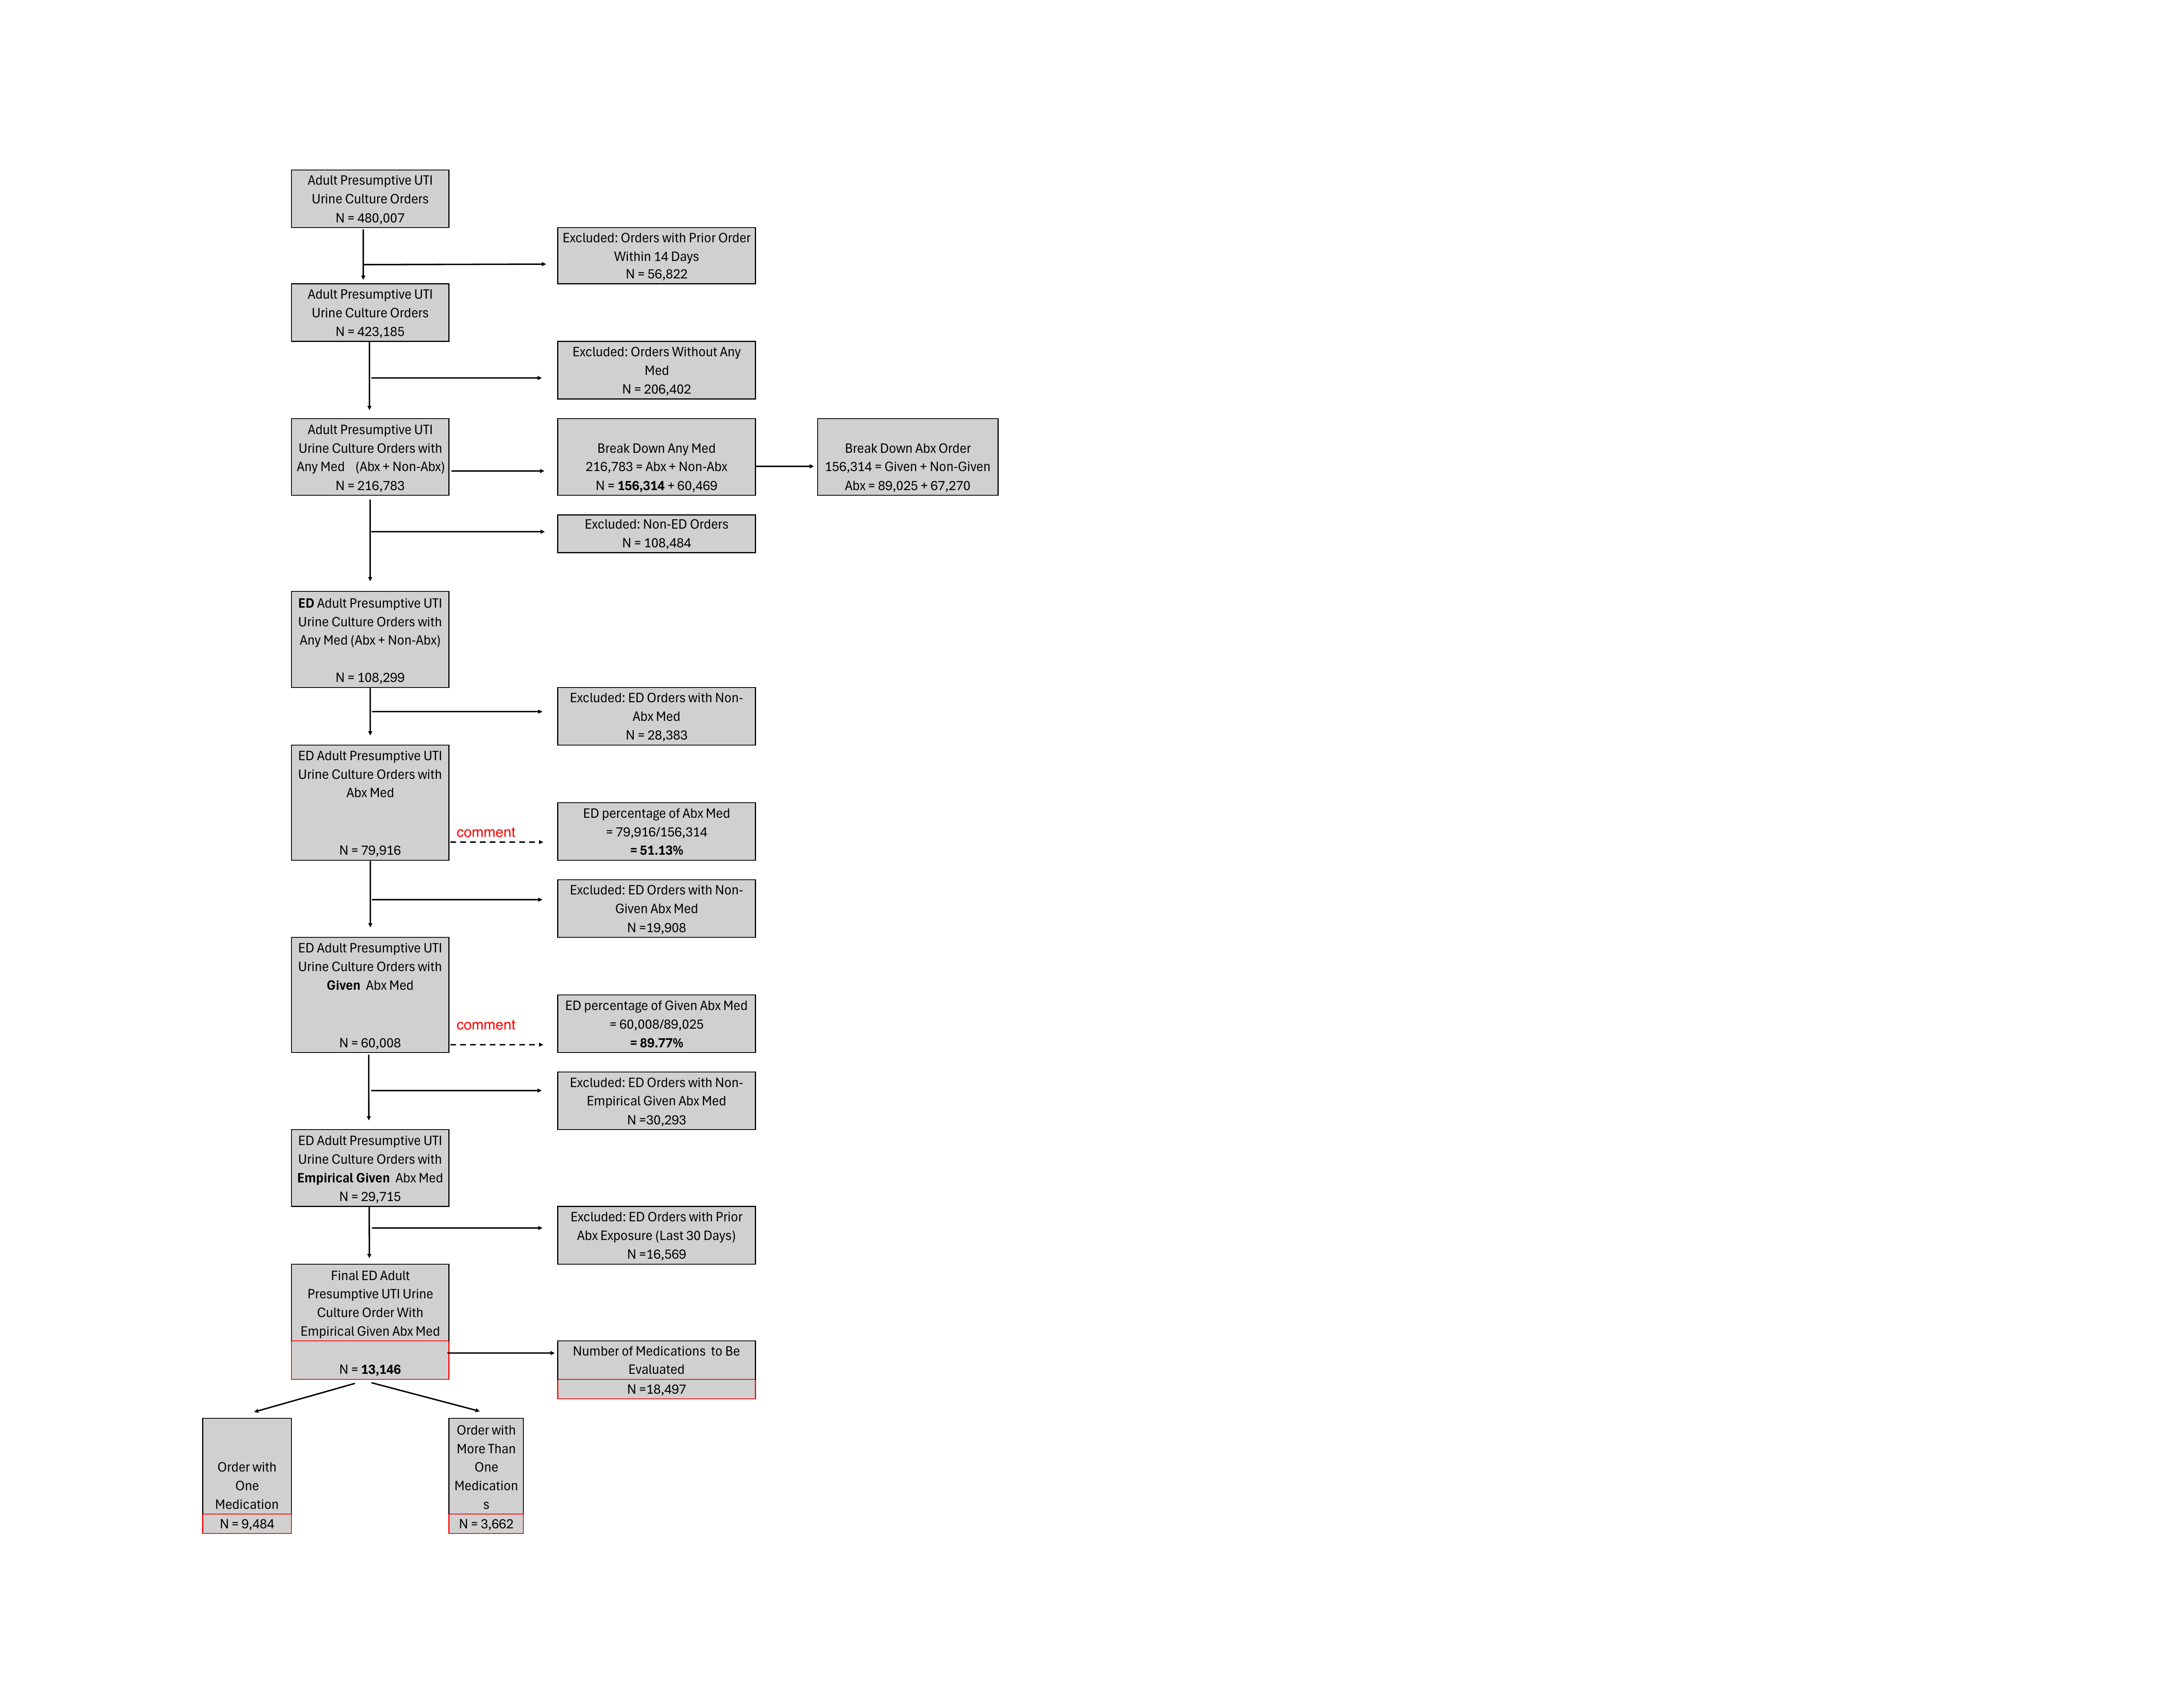

In [493]:
# Convert the first page of the PDF
pages = convert_from_path('imgs/Aim_4_Flowchart_Custom.pdf', dpi=500)
path_png = 'imgs/oervall.png'
pages[0].save(path_png, 'PNG')
# Display the image in the notebook
display(Image(filename=path_png))

# ----------------------**Step 1** ------------------------

### Refactor Fateme's code for urine culture only
Reference: https://github.com/HealthRex/CDSS/blob/master/scripts/antibiotic-susceptibility/sql/queries/microbiology_cultures_cohort_query.sql

In [473]:
%%bigquery --use_rest_api all_urine_cohort
-- This query is the main query for creating a table named microbiology_cultures_cohort that forms the basis of the microbiology cultures cohort. 
-- The table is generated through a series of steps, each designed to filter and enrich the dataset. 
-- Once the main cohort table is created, additional features will be added to this table to complete the dataset for analysis.


######################################################################################## 
-- Create or replace the cohort table named microbiology_urine_cultures_cohort
######################################################################################## 


-- Step 1: Extract microbiology cultures for specific types (URINE)
WITH microbiology_cultures AS (
    SELECT DISTINCT
        op.anon_id, 
        op.pat_enc_csn_id_coded, 
        op.order_proc_id_coded, 
        op.order_time_jittered_utc, 
        op.ordering_mode,
        lr.result_time_jittered_utc, # added the result time too
        CASE 
        # check for urine culture ID
            WHEN op.description LIKE '%URINE%' THEN 'URINE'
            ELSE 'OTHER' 
        END AS culture_description  -- Capture the culture type
    FROM 
        `som-nero-phi-jonc101.shc_core_2023.order_proc` op
    INNER JOIN
        `som-nero-phi-jonc101.shc_core_2023.lab_result` lr
    ON
        op.order_proc_id_coded = lr.order_id_coded
    WHERE
        op.order_type LIKE "Microbiology%"
        AND (op.description LIKE "%URINE%")
), # Only keep urine culture


######################################################################################## 
-- Step 2: Filter for adult patients only
########################################################################################    

adult_microbiology_cultures AS (
    SELECT 
        mc.anon_id, 
        mc.pat_enc_csn_id_coded, 
        mc.order_proc_id_coded, 
        mc.order_time_jittered_utc, 
        mc.ordering_mode,
        mc.culture_description, -- Include culture_description here
        mc.result_time_jittered_utc

    FROM 
        microbiology_cultures mc
    INNER JOIN
        `som-nero-phi-jonc101.shc_core_2023.demographic` demo
    USING
        (anon_id)
    WHERE
        DATE_DIFF(CAST(mc.order_time_jittered_utc as DATE), demo.BIRTH_DATE_JITTERED, YEAR) >= 18
         
)

select * from adult_microbiology_cultures


Query is running:   0%|          |

Downloading:   0%|          |

<Axes: title={'center': 'Number of Unique Urine Culture Orders per Year'}, xlabel='Year', ylabel='Number of Orders'>

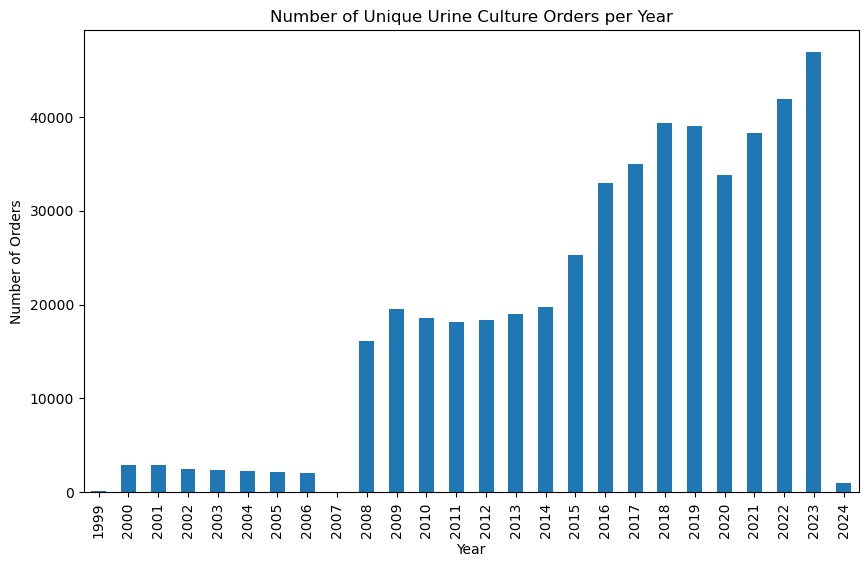

In [511]:
all_urine_cohort["order_time_jittered_utc"].dt.year.value_counts().sort_index().plot(kind='bar', title='Number of Unique Urine Culture Orders per Year', xlabel='Year', ylabel='Number of Orders', figsize=(10, 6))

In [474]:
print("the unique order number for all urine culture is {}".format(find_unique_orders(all_urine_cohort)))

the unique order number for all urine culture is 480007


# -----------------------**Step 2** ----------------------
# After review with Nick and Fatemeh on Apr 11th, we decided to keep all urine culture (keep orders with prior order within 2 weeks)

In [7]:
%%bigquery --use_rest_api starting_cohort
-- This query is the main query for creating a table named microbiology_cultures_cohort that forms the basis of the microbiology cultures cohort. 
-- The table is generated through a series of steps, each designed to filter and enrich the dataset. 
-- Once the main cohort table is created, additional features will be added to this table to complete the dataset for analysis.


######################################################################################## 
-- Create or replace the cohort table named microbiology_urine_cultures_cohort
######################################################################################## 


-- Step 1: Extract microbiology cultures for specific types (URINE)
WITH microbiology_cultures AS (
    SELECT DISTINCT
        op.anon_id, 
        op.pat_enc_csn_id_coded, 
        op.order_proc_id_coded, 
        op.order_time_jittered_utc, 
        op.ordering_mode,
        lr.result_time_jittered_utc, # added the result time too
        CASE 
            WHEN op.description LIKE '%URINE%' THEN 'URINE'
            ELSE 'OTHER' 
        END AS culture_description  -- Capture the culture type
    FROM 
        `som-nero-phi-jonc101.shc_core_2023.order_proc` op
    INNER JOIN
        `som-nero-phi-jonc101.shc_core_2023.lab_result` lr
    ON
        op.order_proc_id_coded = lr.order_id_coded
    WHERE
        op.order_type LIKE "Microbiology%"
        # AND op.ordering_mode LIKE "Inpatient"
        AND (op.description LIKE "%URINE%")
), # Only keep urine culture


######################################################################################## 
-- Step 2: Filter for adult patients only
########################################################################################    

adult_microbiology_cultures AS (
    SELECT 
        mc.anon_id, 
        mc.pat_enc_csn_id_coded, 
        mc.order_proc_id_coded, 
        mc.order_time_jittered_utc, 
        mc.ordering_mode,
        mc.culture_description, -- Include culture_description here
        mc.result_time_jittered_utc

    FROM 
        microbiology_cultures mc
    INNER JOIN
        `som-nero-phi-jonc101.shc_core_2023.demographic` demo
    USING
        (anon_id)
    WHERE
        DATE_DIFF(CAST(mc.order_time_jittered_utc as DATE), demo.BIRTH_DATE_JITTERED, YEAR) >= 18
),

    
######################################################################################## 
-- Step 3: Identify culture orders within the prior two weeks
########################################################################################     
    
# order_in_prior_two_weeks AS (
#     SELECT DISTINCT
#          auc.order_proc_id_coded
#     FROM 
#         `som-nero-phi-jonc101.shc_core_2023.order_proc` op
#     INNER JOIN
#         `som-nero-phi-jonc101.shc_core_2023.lab_result` lr
#     ON
#         op.order_proc_id_coded = lr.order_id_coded
#     INNER JOIN
#         adult_microbiology_cultures auc 
#     ON
#         op.anon_id = auc.anon_id
#     WHERE
#         op.order_type LIKE "Microbiology%"
#         AND (op.description LIKE "%URINE%")
#         AND auc.order_time_jittered_utc > op.order_time_jittered_utc
#         AND TIMESTAMP_DIFF(auc.order_time_jittered_utc, op.order_time_jittered_utc, DAY) < 14
# ),

    
######################################################################################## 
-- Step 4: Exclude cultures with a prior culture order in the last two weeks
########################################################################################       

# included_microbiology_cultures AS (
#     SELECT DISTINCT
#         amc.*
#     FROM 
#         adult_microbiology_cultures amc
#     WHERE 
#         amc.order_proc_id_coded NOT IN (SELECT order_proc_id_coded FROM order_in_prior_two_weeks)
# ),

###########################################################################################################
-- Step 5: Flag cultures as positive if they have corresponding entries in the culture_sensitivity table
###########################################################################################################    

all_cultures_with_flag AS (
    SELECT 
        imc.anon_id, 
        imc.pat_enc_csn_id_coded, 
        imc.order_proc_id_coded, 
        imc.order_time_jittered_utc, 
        imc.result_time_jittered_utc,
        imc.ordering_mode,
        imc.culture_description,
        IF(cs.order_proc_id_coded IS NOT NULL, 1, 0) AS was_positive
    FROM 
        adult_microbiology_cultures imc # i replaced `included_microbiology_cultures` with `adult_microbiology_cultures`
    LEFT JOIN 
        (SELECT DISTINCT order_proc_id_coded FROM `som-nero-phi-jonc101.shc_core_2023.culture_sensitivity`) cs
    ON 
        imc.order_proc_id_coded = cs.order_proc_id_coded
),


#########################################################################################################################
-- Step 6: Get detailed information for positive cultures, clean antibiotic names, and exclude non-antibiotic entries
#########################################################################################################################     
positive_culture_details AS (
    SELECT 
        cs.order_proc_id_coded,
        cs.organism,
        -- Clean and standardize the antibiotic name using the updated cleaning approach
        INITCAP(TRIM(
          REGEXP_REPLACE(
          REGEXP_REPLACE(
          REGEXP_REPLACE(
          REGEXP_REPLACE(
            REGEXP_REPLACE(
                REGEXP_REPLACE(
                    LOWER(cs.antibiotic),
                    'penicillin[^a-z].*$', 'penicillin'
                ),
                '^[^a-z]*|\\s+\\S*[^a-z\\s]+.*$|\\.+$', ''
            ),
              '\\s*\\d+(\\.\\d+)?\\s*(mg|mcg|gram|ml|%)', ''  -- Remove dosages or concentrations
          ),
          '\\(.*?\\)', ''  -- Remove text in parentheses
        ),' in.*$|tablet|capsule|intravenous|piggyback|' ||
                            'solution|suspension|oral|sodium|chloride|' ||
                            'injection|citrate|soln|dextrose|iv|' ||
                            'macrocrystals|macrocrystal|axetil|potassium|packet|' ||
                            'monohydrate|ethylsuccinate|powder|mandelate|' ||
                            'hyclate|hcl|hippurate|tromethamine|' ||
                            'million|unit|syrup|chewable|delayed|mphase|' ||
                            'release|benzathine|syringe|dispersible|' ||
                            'sulfate|procaine|blue|hyos|sod*phos|' ||
                            'susp|and|fosamil|extended|succinate|granules|' ||
                            'delay|pot|ext|rel|cyam|salicylate|salicyl|' ||
                            'sodphos|methylene|stearate|synergy', ''                   
        ),
        '\\d|\\sfor\\s*|/ml\\s*|\\sml\\s*|\\-+\\s*|\\,+\\s*',''
        )
        )
      )  AS antibiotic,
        cs.suscept AS susceptibility
    FROM 
        som-nero-phi-jonc101.shc_core_2023.culture_sensitivity cs
    INNER JOIN (
        -- Subquery to get antibiotic counts for those with more than 10 occurrences
        SELECT 
          INITCAP(TRIM(
          REGEXP_REPLACE(
          REGEXP_REPLACE(
          REGEXP_REPLACE(
          REGEXP_REPLACE(
            REGEXP_REPLACE(
                REGEXP_REPLACE(
                    LOWER(antibiotic),
                    'penicillin[^a-z].*$', 'penicillin'
                ),
                '^[^a-z]*|\\s+\\S*[^a-z\\s]+.*$|\\.+$', ''
            ),
              '\\s*\\d+(\\.\\d+)?\\s*(mg|mcg|gram|ml|%)', ''  -- Remove dosages or concentrations
          ),
          '\\(.*?\\)', ''  -- Remove text in parentheses
        ),' in.*$|tablet|capsule|intravenous|piggyback|' ||
                            'solution|suspension|oral|sodium|chloride|' ||
                            'injection|citrate|soln|dextrose|iv|' ||
                            'macrocrystals|macrocrystal|axetil|potassium|packet|' ||
                            'monohydrate|ethylsuccinate|powder|mandelate|' ||
                            'hyclate|hcl|hippurate|tromethamine|' ||
                            'million|unit|syrup|chewable|delayed|mphase|' ||
                            'release|benzathine|syringe|dispersible|' ||
                            'sulfate|procaine|blue|hyos|sod*phos|' ||
                            'susp|and|fosamil|extended|succinate|granules|' ||
                            'delay|pot|ext|rel|cyam|salicylate|salicyl|' ||
                            'sodphos|methylene|stearate|synergy', ''                   
        ),
        '\\d|\\sfor\\s*|/ml\\s*|\\sml\\s*|\\-+\\s*|\\,+\\s*',''
        )
        )
      )AS cleaned_antibiotic,
            COUNT(*) AS count
        FROM 
            som-nero-phi-jonc101.shc_core_2023.culture_sensitivity
        GROUP BY 
            cleaned_antibiotic
        HAVING 
            COUNT(*) >= 10  -- Include only antibiotics that appear 10 times or more
    ) AS antibiotic_counts 
    ON 


      INITCAP(TRIM(
          REGEXP_REPLACE(
          REGEXP_REPLACE(
          REGEXP_REPLACE(
          REGEXP_REPLACE(
            REGEXP_REPLACE(
                REGEXP_REPLACE(
                    LOWER(cs.antibiotic),
                    'penicillin[^a-z].*$', 'penicillin'
                ),
                '^[^a-z]*|\\s+\\S*[^a-z\\s]+.*$|\\.+$', ''
            ),
              '\\s*\\d+(\\.\\d+)?\\s*(mg|mcg|gram|ml|%)', ''  -- Remove dosages or concentrations
          ),
          '\\(.*?\\)', ''  -- Remove text in parentheses
        ),' in.*$|tablet|capsule|intravenous|piggyback|' ||
                            'solution|suspension|oral|sodium|chloride|' ||
                            'injection|citrate|soln|dextrose|iv|' ||
                            'macrocrystals|macrocrystal|axetil|potassium|packet|' ||
                            'monohydrate|ethylsuccinate|powder|mandelate|' ||
                            'hyclate|hcl|hippurate|tromethamine|' ||
                            'million|unit|syrup|chewable|delayed|mphase|' ||
                            'release|benzathine|syringe|dispersible|' ||
                            'sulfate|procaine|blue|hyos|sod*phos|' ||
                            'susp|and|fosamil|extended|succinate|granules|' ||
                            'delay|pot|ext|rel|cyam|salicylate|salicyl|' ||
                            'sodphos|methylene|stearate|synergy', ''                   
        ),
        '\\d|\\sfor\\s*|/ml\\s*|\\sml\\s*|\\-+\\s*|\\,+\\s*',''
        )
        )
      )= antibiotic_counts.cleaned_antibiotic
    WHERE
        NOT (
            cs.antibiotic LIKE '%InBasket%'  
            OR cs.antibiotic LIKE '%Beta Lactamase%'  
            OR cs.antibiotic LIKE '%BlaZ PCR%'  
            OR cs.antibiotic LIKE '%Carbapenemase%'  
            OR cs.antibiotic LIKE '%D-Test%'  
            OR cs.antibiotic LIKE '%Esbl%'  
            OR cs.antibiotic LIKE '%ermPCR%'  
            OR cs.antibiotic LIKE '%Mupirocin%'  
            OR cs.antibiotic LIKE '%IMP%'  
            OR cs.antibiotic LIKE '%Inducible Clindamycin%'  
            OR cs.antibiotic LIKE '%INTERNAL CONTROL%'  
            OR cs.antibiotic LIKE '%KPC%'  
            OR cs.antibiotic LIKE '%MecA PCR%'  
            OR cs.antibiotic LIKE '%NDM%'  
            OR cs.antibiotic LIKE '%Ox Plate Screen%'  
            OR cs.antibiotic LIKE '%OXA-48-LIKE%'  
            OR cs.antibiotic LIKE '%VIM%'  
            OR cs.antibiotic LIKE '%Method%'  
            OR cs.antibiotic LIKE '%INH%'   
            OR cs.antibiotic LIKE '%Polymyxin B%' 
            OR cs.antibiotic LIKE '%Nalidixic%'   
            OR cs.antibiotic LIKE '%Flucytosine%' 
            OR cs.antibiotic LIKE '%Rifampin%' 
            OR cs.antibiotic LIKE '%Ethambutol%' 
            OR cs.antibiotic LIKE '%Pyrazinamide%' 
            OR cs.antibiotic LIKE '%Clofazimine%' 
            OR cs.antibiotic LIKE '%Rifabutin%' 
            OR cs.antibiotic IN ('Posaconazole','Penicillin/Ampicillin','Omadacycline', 'Amphotericin B', 'Polymixin B', 'Fluconazole', 'Itraconazole', 'Caspofungin', 'Voriconazole', 'Anidulafungin', 'Micafungin', 'Isavuconazole', 'Antibiotic', 'OXA48-LIKE PCR', 'ESBL confirmation test', 'Oxacillin Screen')
        )
)

#########################################################################################################################
  -- Step 7: Final selection of required fields
#########################################################################################################################   

SELECT 
    acwf.anon_id,
    acwf.pat_enc_csn_id_coded,
    acwf.order_proc_id_coded,
    acwf.order_time_jittered_utc,
    acwf.result_time_jittered_utc,
    acwf.ordering_mode,
    acwf.culture_description,
    acwf.was_positive,
    pcd.organism,
    pcd.antibiotic,
    CASE
        WHEN pcd.susceptibility IS NULL THEN NULL  -- Keep NULL values unchanged
        WHEN pcd.susceptibility IN ('Susceptible', 'Not Detected', 'Negative' ) THEN 'Susceptible'
        WHEN pcd.susceptibility IN ('Resistant', 'Non Susceptible', 'Positive', 'Detected') THEN 'Resistant'
        WHEN pcd.susceptibility IN ('Intermediate', 'Susceptible - Dose Dependent') THEN 'Intermediate'
        WHEN pcd.susceptibility IN ('No Interpretation', 'Not done', 'Inconclusive', 'See Comment') THEN 'Inconclusive'
        WHEN pcd.susceptibility IN ('Synergy', 'No Synergy') THEN 'Synergism'
        ELSE 'Unknown'  -- Mark unexpected values as Unknown
    END AS susceptibility
FROM
    all_cultures_with_flag acwf
LEFT JOIN
    positive_culture_details pcd
ON
    acwf.order_proc_id_coded = pcd.order_proc_id_coded
WHERE
    -- Exclude rows where susceptibility would be 'Unknown'
    (pcd.susceptibility IS NULL OR
    pcd.susceptibility IN ('Susceptible', 'Positive', 'Detected',
                           'Resistant', 'Non Susceptible', 'Negative',
                           'Intermediate', 'Susceptible - Dose Dependent',
                           'No Interpretation', 'Not done', 'Inconclusive', 'See Comment',
                           'Synergy', 'No Synergy', 'Not Detected'));


Query is running:   0%|          |

Downloading:   0%|          |

In [230]:
condition = (starting_cohort['was_positive'] == 1) & (starting_cohort["organism"].isnull())
print("the unique order number for adult urine only culture is {}".format(find_unique_orders(starting_cohort[~condition])))
print("the unique patient encounter number for adult urine only culture is {}".format(find_unique_patient_encounter(starting_cohort[~condition])))

the unique order number for adult urine only culture is 479615
the unique patient encounter number for adult urine only culture is 439923


In [8]:
print("the unique order number for adult urine only culture is {}".format(find_unique_orders(starting_cohort)))

the unique order number for adult urine only culture is 480007


In [9]:
print("the unique patient encounter number for adult urine only culture is {}".format(find_unique_patient_encounter(starting_cohort)))

the unique patient encounter number for adult urine only culture is 440088


<Axes: title={'center': 'Number of Unique Urine Culture Orders per Year'}, xlabel='Year', ylabel='Number of Orders'>

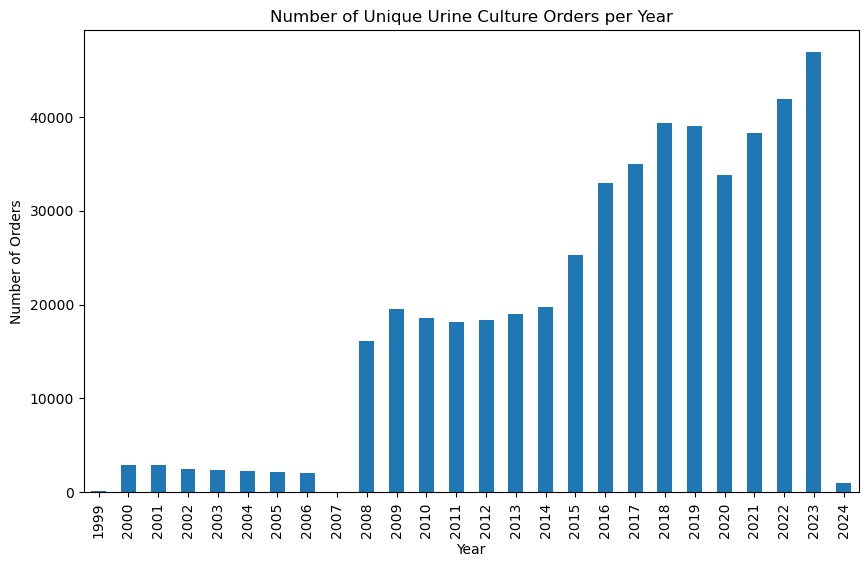

In [10]:
unique_order_starting_cohort = starting_cohort.drop_duplicates(subset=['anon_id', 'pat_enc_csn_id_coded', 'order_proc_id_coded', 'order_time_jittered_utc'])
# find_unique_orders(unique_order_starting_cohort)
# 423185
unique_order_starting_cohort["order_time_jittered_utc"].dt.year.value_counts().sort_index().plot(kind='bar', title='Number of Unique Urine Culture Orders per Year', xlabel='Year', ylabel='Number of Orders', figsize=(10, 6))

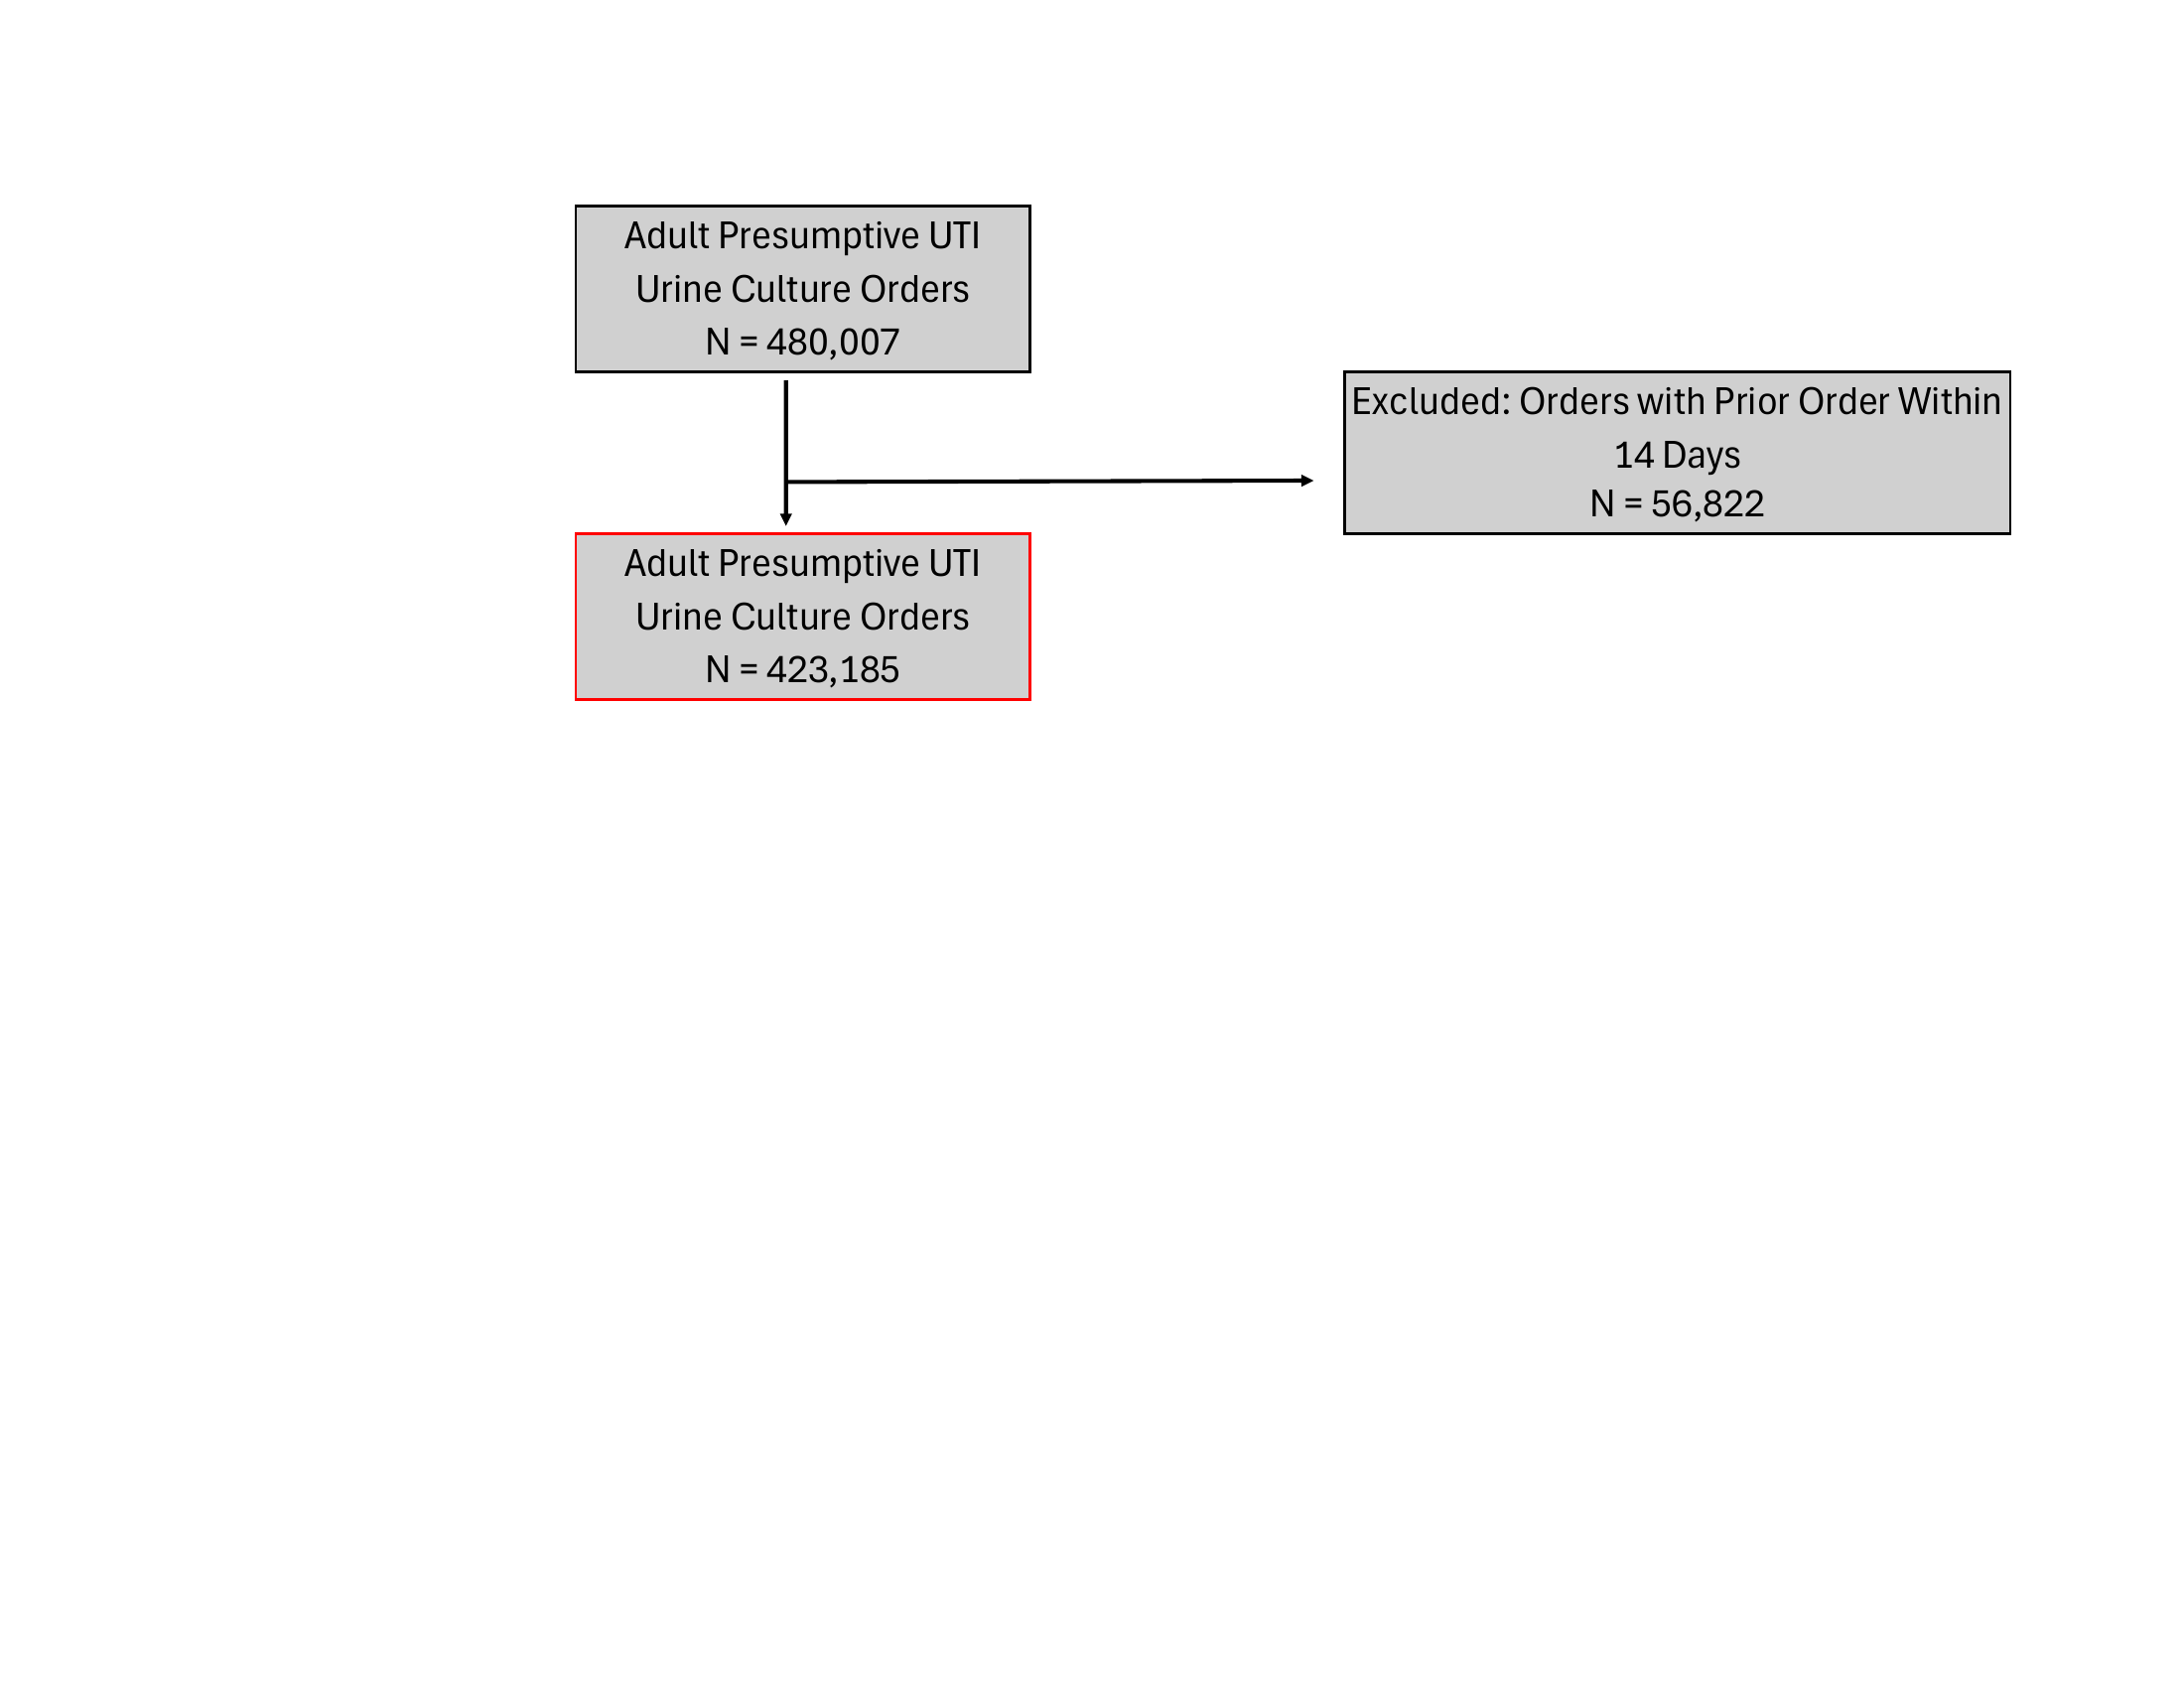

In [567]:
# pages = convert_from_path('imgs/Aim_4_Flowchart_Custom.pdf', dpi=200)
# path_png = 'imgs/step1-2.png'
# pages[1].save(path_png, 'PNG')
# # Display the image in the notebook
# display(Image(filename=path_png))

# ---------------------**Step 3** -----------------------

## 🔍 Verifying Current Medications in the Cohort

To analyze the **current (empirical + non-empirical) medications** for the orders in the above cohort, I applied the following steps:

### ✅ Methodology:
1. **Filtered for current medications only** to focus on active prescriptions.  
2. **Retained the original medication names** without using `regex_express` for modifications.  
3. **Incorporated pharmacy data** (`pharmacy_mar`) after the weekly meeting on **March 20th** to determine whether the ordered medication was actually administered.  
4. **Updated medication_time** we updated `medication_time` from `ordering_date_jittered_utc` from table `order_med` to `taken_time_jittered` from table `pharmacy_mar` after meeting on **Apr 11th**

# ---------------------**Step 3.1** -----------------------
# To debug, we focus on the inpateint and inpatient ED first

In [43]:
# # Check if there are rows where medication_name is null but medication_action is not null
# condition = current_med_original_no_mapped_with_12_hours_temp[
#     current_med_original_no_mapped_with_12_hours_temp["medication_name"].isnull() &
#     current_med_original_no_mapped_with_12_hours_temp["medication_action"].notnull()
# ]

# # If the condition is empty, it means the combination is not possible
# if condition.empty:
#     print("When medication_name is null, medication_action is always null.")
# else:
#     print("There are cases where medication_name is null but medication_action is not null.")
#     print(condition)

When medication_name is null, medication_action is always null.


In [36]:
# unique_order_starting_cohort["order_time_jittered_utc"].dt.year.value_counts().sort_index()
# Combine the value_counts from both dataframes
combined_counts = pd.DataFrame({
    "unique_order_starting_cohort": unique_order_starting_cohort["order_time_jittered_utc"].dt.year.value_counts().sort_index(),
    "unique_order_starting_cohort_merged": unique_order_starting_cohort_merged["medication_time"].dt.year.value_counts().sort_index()
}).reset_index()

# Rename the columns for clarity
combined_counts.columns = ["Year", "unique_order_starting_cohort", "unique_order_starting_cohort_merged"]

# Display the combined dataframe
combined_counts["diff"] = combined_counts["unique_order_starting_cohort"] - combined_counts["unique_order_starting_cohort_merged"]
# unique_order_starting_cohort_merged["order_time_jittered_utc"].dt.year.value_counts().sort_index()
combined_counts


,Year,unique_order_starting_cohort,unique_order_starting_cohort_merged,diff
0,1999.0,85,NaN,NaN
1,2000.0,2943,NaN,NaN
2,2001.0,2888,NaN,NaN
3,2002.0,2426,NaN,NaN
4,2003.0,2335,NaN,NaN
5,2004.0,2294,NaN,NaN
6,2005.0,2206,NaN,NaN
7,2006.0,2015,NaN,NaN
8,2007.0,1,NaN,NaN
9,2008.0,16122,7153.0,8969.0


# ------------inpatient only---------

In [13]:
%%bigquery --use_rest_api current_med_original_no_mapped_with_12_hours_inpatient_temp
WITH base_c AS (
    SELECT DISTINCT
        anon_id,
        pat_enc_csn_id_coded,
        order_proc_id_coded,
        order_time_jittered_utc,
        result_time_jittered_utc,
        ordering_mode
    FROM 
        `som-nero-phi-jonc101.antimicrobial_stewardship_sandy_refactor.microbiology_urine_cultures_cohort`
    where ordering_mode='Inpatient' # focus on the inpatient setting
),

-- Inner join between order_med and pharmacy_mar
medications_joined AS (
    SELECT 
        mo.anon_id,
        mo.order_med_id_coded,
        # mo.ordering_date_jittered_utc AS medication_time,
        mo.med_description AS medication_name,
        mar.mar_action AS medication_action,
        mar.taken_time_jittered_utc AS medication_time, # new medication_time
        mo.pat_enc_csn_id_coded

    FROM 
        `som-nero-phi-jonc101.shc_core_2023.order_med` mo
    INNER JOIN 
        `som-nero-phi-jonc101.shc_core_2023.pharmacy_mar` mar
    ON 
        mo.anon_id = mar.anon_id 
        AND mo.order_med_id_coded = mar.order_med_id_coded
),

-- Join base_c with the combined medication data, within 12 hours
cleaned_medications AS (
    SELECT 
        c.anon_id,
        c.pat_enc_csn_id_coded,
        c.order_proc_id_coded,
        c.order_time_jittered_utc,
        c.result_time_jittered_utc,
        c.ordering_mode,
        m.medication_time,
        m.medication_name,
        m.order_med_id_coded,
        m.medication_action
    FROM 
        base_c c
    LEFT JOIN 
        medications_joined m
    ON 
        c.anon_id = m.anon_id
        AND (
        (
            c.pat_enc_csn_id_coded = m.pat_enc_csn_id_coded
            OR ABS(TIMESTAMP_DIFF(m.medication_time, c.order_time_jittered_utc, HOUR)) <= 12  -- subjective window
        )
        OR (
            m.medication_time > c.order_time_jittered_utc
            AND m.medication_time <= c.result_time_jittered_utc
        )
    )

        # AND ABS(TIMESTAMP_DIFF(m.medication_time, c.order_time_jittered_utc, HOUR)) <= 12 # this is subjective 
  
)

SELECT *
FROM cleaned_medications
GROUP BY 
    anon_id,
    pat_enc_csn_id_coded,
    order_proc_id_coded,
    order_time_jittered_utc,
    result_time_jittered_utc,
    ordering_mode,
    medication_time,
    medication_name,
    order_med_id_coded,
    medication_action
ORDER BY 
    anon_id,
    pat_enc_csn_id_coded,
    order_proc_id_coded,
    order_time_jittered_utc,
    result_time_jittered_utc,
    ordering_mode,
    medication_time,
    medication_name,
    order_med_id_coded,
    medication_action

Query is running:   0%|          |

Downloading:   0%|          |

In [231]:
current_med_original_no_mapped_with_12_hours_inpatient_temp

,anon_id,pat_enc_csn_id_coded,order_proc_id_coded,order_time_jittered_utc,result_time_jittered_utc,ordering_mode,medication_time,medication_name,order_med_id_coded,medication_action,cleaned_antibiotic
0,JC1000013,15196628,325085592,2008-04-16 04:30:00+00:00,2008-04-17 01:22:00+00:00,Inpatient,2008-04-22 12:10:00+00:00,HYDROCODONE-ACETAMINOPHEN 5-500 MG PO TABS,325234169,Given,No Match
1,JC1000013,15196628,325085592,2008-04-16 04:30:00+00:00,2008-04-17 01:22:00+00:00,Inpatient,2008-04-22 15:00:00+00:00,ENOXAPARIN 30 MG/0.3 ML SC SYRG,325234165,Given,No Match
2,JC1000013,15196628,325085592,2008-04-16 04:30:00+00:00,2008-04-17 01:22:00+00:00,Inpatient,2008-04-22 15:00:00+00:00,FERROUS SULFATE 325 MG (65 MG IRON) PO TABS,325234166,Given,No Match
3,JC1000013,15196628,325085592,2008-04-16 04:30:00+00:00,2008-04-17 01:22:00+00:00,Inpatient,2008-04-22 16:27:00+00:00,HYDROCODONE-ACETAMINOPHEN 5-500 MG PO TABS,325234169,Given,No Match
4,JC1000013,15196628,325085592,2008-04-16 04:30:00+00:00,2008-04-17 01:22:00+00:00,Inpatient,2008-04-22 22:04:00+00:00,HYDROCODONE-ACETAMINOPHEN 5-500 MG PO TABS,325234169,Given,No Match
...,...,...,...,...,...,...,...,...,...,...,...
90074215,JC999925,131107270857,471989931,2015-08-09 09:12:00+00:00,2015-08-11 14:59:00+00:00,Inpatient,2015-08-20 15:43:00+00:00,METOPROLOL TARTRATE 25 MG PO TABS,471942713,Given,No Match
90074216,JC999925,131107270857,471989931,2015-08-09 09:12:00+00:00,2015-08-11 14:59:00+00:00,Inpatient,2015-08-20 15:43:00+00:00,ZZZ IMS TEMPLATE,472018107,Given,No Match
90074217,JC999925,131107270857,471989931,2015-08-09 09:12:00+00:00,2015-08-11 14:59:00+00:00,Inpatient,2015-08-20 15:43:00+00:00,ZZZ IMS TEMPLATE,472905353,Given,No Match
90074218,JC999925,131107270857,471989931,2015-08-09 09:12:00+00:00,2015-08-11 14:59:00+00:00,Inpatient,2015-08-20 19:00:00+00:00,ALPRAZOLAM 0.5 MG PO TB24,472056138,Missed,No Match


In [14]:
find_unique_orders(current_med_original_no_mapped_with_12_hours_inpatient_temp)

228555

<Axes: title={'center': 'Number of Unique Urine Culture Orders per Year'}, xlabel='Year', ylabel='Number of Orders'>

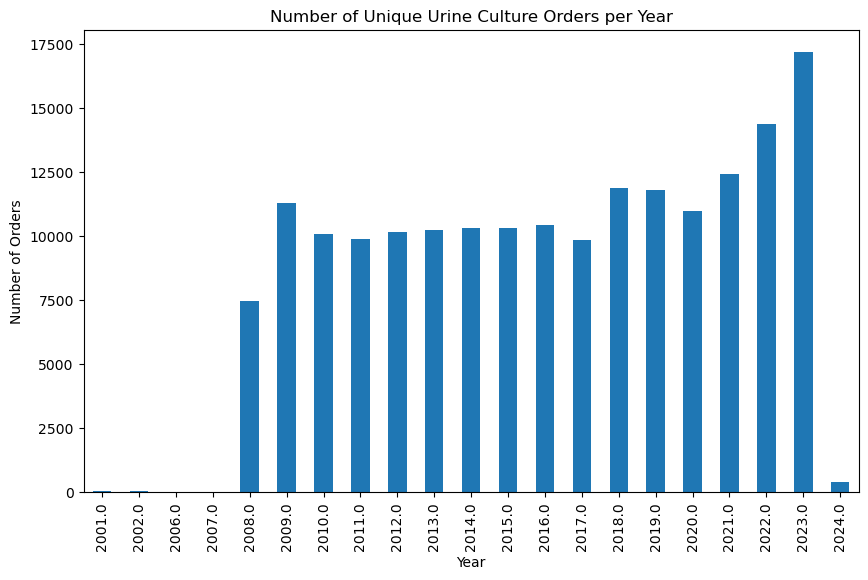

In [15]:
unique_order_inp_cohort_merged = current_med_original_no_mapped_with_12_hours_inpatient_temp.drop_duplicates(subset=['anon_id', 'pat_enc_csn_id_coded', 'order_proc_id_coded', 'order_time_jittered_utc'])
unique_order_inp_cohort_merged["medication_time"].dt.year.value_counts().sort_index().plot(kind='bar', title='Number of Unique Urine Culture Orders per Year', xlabel='Year', ylabel='Number of Orders', figsize=(10, 6))

In [29]:
# unique_order_starting_cohort["order_time_jittered_utc"].dt.year.value_counts().sort_index()
# Combine the value_counts from both dataframes
combined_counts = pd.DataFrame({
    "unique_order_starting_cohort": unique_order_starting_cohort["order_time_jittered_utc"].dt.year.value_counts().sort_index(),
    "unique_order_inp_cohort_merged": unique_order_inp_cohort_merged["order_time_jittered_utc"].dt.year.value_counts().sort_index()
}).reset_index()

# Rename the columns for clarity
combined_counts.columns = ["Year", "unique_order_starting_cohort", "unique_order_inp_cohort_merged"]

# Display the combined dataframe
combined_counts["diff"] = combined_counts["unique_order_starting_cohort"] - combined_counts["unique_order_inp_cohort_merged"]
combined_counts


,Year,unique_order_starting_cohort,unique_order_starting_cohort_merged,diff
0,1999,85,NaN,NaN
1,2000,2943,NaN,NaN
2,2001,2888,NaN,NaN
3,2002,2426,NaN,NaN
4,2003,2335,NaN,NaN
5,2004,2294,NaN,NaN
6,2005,2206,NaN,NaN
7,2006,2015,NaN,NaN
8,2007,1,NaN,NaN
9,2008,16122,9811.0,6311.0


In [ ]:
# # Check if there are rows where medication_name is null but medication_action is not null
# condition = current_med_original_no_mapped_with_12_hours_inpatient_temp[
#     current_med_original_no_mapped_with_12_hours_inpatient_temp["medication_name"].isnull() &
#     current_med_original_no_mapped_with_12_hours_inpatient_temp["medication_action"].notnull()
# ]

# # If the condition is empty, it means the combination is not possible
# if condition.empty:
#     print("When medication_name is null, medication_action is always null.")
# else:
#     print("There are cases where medication_name is null but medication_action is not null.")
#     print(condition)

When medication_name is null, medication_action is always null.


In [18]:
current_med_original_no_mapped_with_12_hours_inpatient_temp.head(10)

,anon_id,pat_enc_csn_id_coded,order_proc_id_coded,order_time_jittered_utc,result_time_jittered_utc,ordering_mode,medication_time,medication_name,order_med_id_coded,medication_action
0,JC1000013,15196628,325085592,2008-04-16 04:30:00+00:00,2008-04-17 01:22:00+00:00,Inpatient,2008-04-22 12:10:00+00:00,HYDROCODONE-ACETAMINOPHEN 5-500 MG PO TABS,325234169,Given
1,JC1000013,15196628,325085592,2008-04-16 04:30:00+00:00,2008-04-17 01:22:00+00:00,Inpatient,2008-04-22 15:00:00+00:00,ENOXAPARIN 30 MG/0.3 ML SC SYRG,325234165,Given
2,JC1000013,15196628,325085592,2008-04-16 04:30:00+00:00,2008-04-17 01:22:00+00:00,Inpatient,2008-04-22 15:00:00+00:00,FERROUS SULFATE 325 MG (65 MG IRON) PO TABS,325234166,Given
3,JC1000013,15196628,325085592,2008-04-16 04:30:00+00:00,2008-04-17 01:22:00+00:00,Inpatient,2008-04-22 16:27:00+00:00,HYDROCODONE-ACETAMINOPHEN 5-500 MG PO TABS,325234169,Given
4,JC1000013,15196628,325085592,2008-04-16 04:30:00+00:00,2008-04-17 01:22:00+00:00,Inpatient,2008-04-22 22:04:00+00:00,HYDROCODONE-ACETAMINOPHEN 5-500 MG PO TABS,325234169,Given
5,JC1000013,15196628,325085592,2008-04-16 04:30:00+00:00,2008-04-17 01:22:00+00:00,Inpatient,2008-04-23 02:42:24+00:00,HYDROCODONE-ACETAMINOPHEN 5-500 MG PO TABS,325234169,Given
6,JC1000013,15196628,325085592,2008-04-16 04:30:00+00:00,2008-04-17 01:22:00+00:00,Inpatient,2008-04-23 03:05:30+00:00,ENOXAPARIN 30 MG/0.3 ML SC SYRG,325234165,Given
7,JC1000013,15196628,325085592,2008-04-16 04:30:00+00:00,2008-04-17 01:22:00+00:00,Inpatient,2008-04-23 07:09:32+00:00,HYDROCODONE-ACETAMINOPHEN 5-500 MG PO TABS,325234169,Given
8,JC1000013,15196628,325085592,2008-04-16 04:30:00+00:00,2008-04-17 01:22:00+00:00,Inpatient,2008-04-23 13:24:20+00:00,HYDROCODONE-ACETAMINOPHEN 5-500 MG PO TABS,325234169,Given
9,JC1000013,15196628,325085592,2008-04-16 04:30:00+00:00,2008-04-17 01:22:00+00:00,Inpatient,2008-04-23 15:09:28+00:00,FERROUS SULFATE 325 MG (65 MG IRON) PO TABS,325234166,Given


In [19]:
print("the number of unique orders for current_med_original_no_mapped_with_12_hours_inpatient_temp is {}".format(find_unique_orders(current_med_original_no_mapped_with_12_hours_inpatient_temp)))
print("the number of unique patient encounters for current_med_original_no_mapped_with_12_hours_inpatient_temp is {}".format(find_unique_patient_encounter(current_med_original_no_mapped_with_12_hours_inpatient_temp)))

the number of unique orders for current_med_original_no_mapped_with_12_hours_inpatient_temp is 228555
the number of unique patient encounters for current_med_original_no_mapped_with_12_hours_inpatient_temp is 201213


In [21]:
# classify the medication name into antibiotic or not
current_med_original_no_mapped_with_12_hours_inpatient_temp["cleaned_antibiotic"] = current_med_original_no_mapped_with_12_hours_inpatient_temp["medication_name"].apply(
    lambda x: find_antibiotics(x, antibiotic_list)
)

In [232]:
# check how many patient encounter given any medication
condition = current_med_original_no_mapped_with_12_hours_inpatient_temp["medication_name"].notna() 
any_med_inp= current_med_original_no_mapped_with_12_hours_inpatient_temp[condition]
any_med_inp_pat_enc_cnt = find_unique_patient_encounter(any_med_inp)
total_inp_pat_enc_cnt = find_unique_patient_encounter(current_med_original_no_mapped_with_12_hours_inpatient_temp)
print("the unique patient encounter number with current medication is {}".format(any_med_inp_pat_enc_cnt))
percentage = any_med_inp_pat_enc_cnt/total_inp_pat_enc_cnt *100
print("the percentage of unique patient encounter with any medication (out of all inpatients) is {:.2f}%".format(percentage))
print("----------------------------------------------------------")
any_med_inp_order_cnt = find_unique_orders(any_med_inp)
total_inp_order_cnt = find_unique_orders(current_med_original_no_mapped_with_12_hours_inpatient_temp)
print("the unique culture order with current medication is {}".format(any_med_inp_order_cnt))
percentage = any_med_inp_order_cnt/total_inp_order_cnt *100
print("the percentage of unique culture order with any medication (out of all inpatients) is {:.2f}%".format(percentage))

the unique patient encounter number with current medication is 152546
the percentage of unique patient encounter with any medication (out of all inpatients) is 75.81%
----------------------------------------------------------
the unique culture order with current medication is 178984
the percentage of unique culture order with any medication (out of all inpatients) is 78.31%


### The above code shows that out of all inpatient encounter (**`N = 201213`**), `75.81%` (`n = 152546`) has medication (abx or non-abx)
201213 --> 152546

In [23]:
# check how many orders given any antibiotic out of all medication order
condition = current_med_original_no_mapped_with_12_hours_inpatient_temp["medication_name"].notna() 
any_med_inp= current_med_original_no_mapped_with_12_hours_inpatient_temp[condition]
condition = any_med_inp["cleaned_antibiotic"] != "No Match"
abx_med_inp = any_med_inp[condition]
abx_med_inp_pat_enc_cnt= find_unique_patient_encounter(abx_med_inp)
print("the unique patient encounter number with current abx medication is {}".format(abx_med_inp_pat_enc_cnt))
percentage = abx_med_inp_pat_enc_cnt/any_med_inp_pat_enc_cnt *100
print("the percentage of unique patient encounter with current abx medication(out of any med) is {:.2f}%".format(percentage))
print("----------------------------------------------------------")
abx_med_inp_order_cnt = find_unique_orders(abx_med_inp)
print("the unique culture order with current abx medication is {}".format(abx_med_inp_order_cnt))
percentage = abx_med_inp_order_cnt/any_med_inp_order_cnt *100
print("the percentage of unique culture order with current abx medication (out of any med) is {:.2f}%".format(percentage))

the unique patient encounter number with current abx medication is 108872
the percentage of unique patient encounter with current abx medication(out of any med) is 71.37%
----------------------------------------------------------
the unique culture order with current abx medication is 134150
the percentage of unique culture order with current abx medication (out of any med) is 74.95%


### The above code shows that out of all inpatient encounter with any medication `n = 150068`, `64.95%` (`n = 97468`) has abx medication
201213 --> 150068 --> 97468

# ------------------------ ED Inpatient Only --------------------

### Refactor Fateme's code for ward info in order to select ED order
Reference: https://github.com/HealthRex/CDSS/blob/master/scripts/antibiotic-susceptibility/sql/queries/microbiology_cultures_ward_info.sql

In [ ]:
%%bigquery --use_rest_api df_hosp_ward_info
WITH
-- Step 1: Extract ER and ICU Information from adt Table
temp_er_icu_info_adt AS (
    SELECT
        anon_id,
        pat_enc_csn_id_coded,
        CASE 
            WHEN pat_class = 'Emergency' OR pat_class = 'Emergency Services' THEN 1
            ELSE 0
        END AS hosp_ward_ER,
        CASE 
            WHEN pat_class = 'Intensive Care (IC)' THEN 1
            ELSE 0
        END AS hosp_ward_ICU,
        CASE 
            WHEN pat_lv_of_care LIKE "%Critical Care" THEN 1
            ELSE 0
        END AS hosp_ward_Critical_Care
    FROM
        `som-nero-phi-jonc101.shc_core_2023.adt`
),

-- Step 2: Extract ER Information from order_proc Table
temp_er_info_order_proc AS (
    SELECT
        anon_id,
        pat_enc_csn_id_coded,
        order_proc_id_coded,
        CASE 
            WHEN proc_pat_class = 'Emergency' OR proc_pat_class = 'Emergency Services' THEN 1
            ELSE 0
        END AS hosp_ward_ER_order_proc
    FROM
        `som-nero-phi-jonc101.shc_core_2023.order_proc`
),

-- Step 3: Combine ER and ICU Information
temp_combined_er_icu_info AS (
    SELECT
        adt.anon_id,
        adt.pat_enc_csn_id_coded,
        adt.hosp_ward_ER,
        adt.hosp_ward_ICU,
        adt.hosp_ward_Critical_Care,
        er.order_proc_id_coded,
        er.hosp_ward_ER_order_proc
    FROM
        temp_er_icu_info_adt adt
    LEFT JOIN
        temp_er_info_order_proc er
    ON
        adt.pat_enc_csn_id_coded = er.pat_enc_csn_id_coded
),

-- Step 4: Extract IP and OP Information from order_proc Table
temp_ip_op_info AS (
    SELECT
        anon_id,
        pat_enc_csn_id_coded,
        order_proc_id_coded,
        order_time_jittered_utc,
        CASE 
            WHEN ordering_mode = 'Inpatient' THEN 1
            ELSE 0
        END AS hosp_ward_IP,
        CASE 
            WHEN ordering_mode = 'Outpatient' THEN 1
            ELSE 0
        END AS hosp_ward_OP
    FROM
        `som-nero-phi-jonc101.shc_core_2023.order_proc`
),

-- Step 5: Combine All Information into One Temporary Table
temp_combined_hosp_ward_info AS (
    SELECT
        ipop.anon_id,
        ipop.pat_enc_csn_id_coded,
        ipop.order_proc_id_coded,
        ipop.order_time_jittered_utc,
        ipop.hosp_ward_IP,
        ipop.hosp_ward_OP,
        COALESCE(icu.hosp_ward_ER, 0) AS hosp_ward_ER_adt,
        COALESCE(icu.hosp_ward_ER_order_proc, 0) AS hosp_ward_ER_order_proc,
        COALESCE(icu.hosp_ward_ICU, 0) AS hosp_ward_ICU,
        COALESCE(icu.hosp_ward_Critical_Care, 0) AS hosp_ward_Critical_Care
    FROM
        temp_ip_op_info ipop
    LEFT JOIN
        temp_combined_er_icu_info icu
    ON
        ipop.pat_enc_csn_id_coded = icu.pat_enc_csn_id_coded AND ipop.order_proc_id_coded = icu.order_proc_id_coded
),

-- Step 6: Extract ICU stay based on transfer orders
temp_cohortOfInterest AS (
    SELECT DISTINCT
        pat_enc_csn_id_coded,
        hosp_disch_time_jittered_utc
    FROM `som-nero-phi-jonc101.shc_core_2023.encounter`
    WHERE hosp_disch_time_jittered_utc IS NOT NULL
),

temp_ordersTransfer AS (
    SELECT DISTINCT
        pat_enc_csn_id_coded,
        description,
        level_of_care,
        service,
        order_inst_jittered_utc
    FROM `som-nero-phi-jonc101.shc_core_2023.order_proc` AS procedures
    WHERE (description LIKE "CHANGE LEVEL OF CARE/TRANSFER PATIENT" OR description LIKE "ADMIT TO INPATIENT") AND level_of_care IS NOT NULL
),

temp_icuTransferCount AS (
    SELECT
        mc.pat_enc_csn_id_coded,
        COUNT(CASE WHEN level_of_care LIKE "Critical Care" THEN 1 END) AS numICUTransfers
    FROM
       `som-nero-phi-jonc101.antimicrobial_stewardship_sandy_refactor.microbiology_urine_cultures_cohort` mc # only change this to the starting cohort above
    LEFT JOIN
        temp_ordersTransfer ot
    ON
        mc.pat_enc_csn_id_coded = ot.pat_enc_csn_id_coded
    GROUP BY
        mc.pat_enc_csn_id_coded
),

microbiology_cultures_with_icu_flag AS (
    SELECT DISTINCT
        mc.anon_id,
        mc.pat_enc_csn_id_coded,
        mc.order_proc_id_coded,
        mc.order_time_jittered_utc,
        CASE WHEN itc.numICUTransfers > 0 THEN 1 ELSE 0 END AS icu_flag
    FROM
       `som-nero-phi-jonc101.antimicrobial_stewardship_sandy_refactor.microbiology_urine_cultures_cohort` mc
    LEFT JOIN
        temp_icuTransferCount itc
    ON
        mc.pat_enc_csn_id_coded = itc.pat_enc_csn_id_coded
)

-- Step 7: Create the Final Table with Correct Binary Indicators for Each Hospital Ward and ICU Flag
SELECT
    mc.anon_id,
    mc.pat_enc_csn_id_coded,
    mc.order_proc_id_coded,
    mc.order_time_jittered_utc,
    MAX(CASE WHEN chwi.hosp_ward_IP = 1 THEN 1 ELSE 0 END) AS hosp_ward_IP,
    MAX(CASE WHEN chwi.hosp_ward_OP = 1 THEN 1 ELSE 0 END) AS hosp_ward_OP,
    MAX(CASE WHEN chwi.hosp_ward_ER_adt = 1 OR chwi.hosp_ward_ER_order_proc = 1 THEN 1 ELSE 0 END) AS hosp_ward_ER,
    MAX(
        CASE 
            WHEN chwi.hosp_ward_ICU = 1 THEN 1 
            WHEN icu_flag.icu_flag = 1 THEN 1 
            WHEN chwi.hosp_ward_Critical_Care = 1 THEN 1
            ELSE 0 
        END
    ) AS hosp_ward_ICU
FROM
   `som-nero-phi-jonc101.antimicrobial_stewardship_sandy_refactor.microbiology_urine_cultures_cohort` mc
LEFT JOIN
    temp_combined_hosp_ward_info chwi
ON
    mc.anon_id = chwi.anon_id 
    AND mc.pat_enc_csn_id_coded = chwi.pat_enc_csn_id_coded 
    AND mc.order_proc_id_coded = chwi.order_proc_id_coded
LEFT JOIN
    microbiology_cultures_with_icu_flag icu_flag
ON
    mc.anon_id = icu_flag.anon_id 
    AND mc.pat_enc_csn_id_coded = icu_flag.pat_enc_csn_id_coded 
    AND mc.order_proc_id_coded = icu_flag.order_proc_id_coded
GROUP BY
    mc.anon_id, 
    mc.pat_enc_csn_id_coded, 
    mc.order_proc_id_coded, 
    mc.order_time_jittered_utc;

In [25]:
%%bigquery --use_rest_api df_hosp_ward_info
select * from som-nero-phi-jonc101.antimicrobial_stewardship_sandy_refactor.microbiology_urine_cultures_ward_info

Query is running:   0%|          |

Downloading:   0%|          |

In [26]:
ED_order = df_hosp_ward_info[df_hosp_ward_info['hosp_ward_ER'] == 1]

In [27]:
All_ED_inp= current_med_original_no_mapped_with_12_hours_inpatient_temp.merge(ED_order, on=['anon_id', 'pat_enc_csn_id_coded', 'order_proc_id_coded', 'order_time_jittered_utc'], how='inner')
All_ED_inp_pat_enc_cnt = find_unique_patient_encounter(All_ED_inp)
print("the unique patient encounter number with ED order is {}".format(All_ED_inp_pat_enc_cnt))
percentage = All_ED_inp_pat_enc_cnt/total_inp_pat_enc_cnt *100
print("the percentage of unique patient encounter with ED order (out of all inpatients) is {:.2f}%".format(percentage))
print("----------------------------------------------------------")
All_ED_inp_order_cnt = find_unique_orders(All_ED_inp)
print("the unique culture order with ED order is {}".format(All_ED_inp_order_cnt))
percentage = All_ED_inp_order_cnt/total_inp_order_cnt *100
print("the percentage of unique culture order with ED order (out of all inpatients) is {:.2f}%".format(percentage))

the unique patient encounter number with ED order is 119737
the percentage of unique patient encounter with ED order (out of all inpatients) is 59.51%
----------------------------------------------------------
the unique culture order with ED order is 132026
the percentage of unique culture order with ED order (out of all inpatients) is 57.77%


### The above code shows that out of all inpatient encounter `n = 201213`, `59.51%` (`n = 119737`) is from ED 


In [28]:
any_med_inp_ed = any_med_inp.merge(ED_order, \
                                   on=['anon_id','pat_enc_csn_id_coded', 
                                        'order_proc_id_coded', 'order_time_jittered_utc'],
                                          how='inner')
any_med_inp_ed_pat_enc_cnt = find_unique_patient_encounter(any_med_inp_ed)
print("the unique patient encounter number with ED order and any medication is {}".format(any_med_inp_ed_pat_enc_cnt))
percentage = any_med_inp_ed_pat_enc_cnt/All_ED_inp_pat_enc_cnt *100
print("the percentage of unique patient encounter with ED order and any medication (out of all ED inpatients) is {:.2f}%".format(percentage))
print("----------------------------------------------------------")
any_med_inp_ed_order_cnt = find_unique_orders(any_med_inp_ed)
print("the unique culture order with ED order and any medication is {}".format(any_med_inp_ed_order_cnt))
percentage = any_med_inp_ed_order_cnt/All_ED_inp_order_cnt *100
print("the percentage of unique culture order with ED order and any medication (out of all ED inpatients) is {:.2f}%".format(percentage))
print("----------------------------------------------------------")
percentage = any_med_inp_ed_pat_enc_cnt/ any_med_inp_pat_enc_cnt *100
print("the percentage of unique patient encounter with ED order and any medication (out of all inpatients with any med) is {:.2f}%".format(percentage))

the unique patient encounter number with ED order and any medication is 108095
the percentage of unique patient encounter with ED order and any medication (out of all ED inpatients) is 90.28%
----------------------------------------------------------
the unique culture order with ED order and any medication is 120310
the percentage of unique culture order with ED order and any medication (out of all ED inpatients) is 91.13%
----------------------------------------------------------
the percentage of unique patient encounter with ED order and any medication (out of all inpatients with any med) is 70.86%


In [29]:
abx_med_inp_ed = abx_med_inp.merge(ED_order, \
                                   on=['anon_id','pat_enc_csn_id_coded', 
                                        'order_proc_id_coded', 'order_time_jittered_utc'],
                                          how='inner')
abx_med_inp_ed_pat_enc_cnt = find_unique_patient_encounter(abx_med_inp_ed)
print("the unique patient encounter number with ED order and abx medication is {}".format(abx_med_inp_ed_pat_enc_cnt))
percentage = abx_med_inp_ed_pat_enc_cnt/All_ED_inp_pat_enc_cnt *100
print("the percentage of unique patient encounter with ED order and abx medication (out of all ED inpatients) is {:.2f}%".format(percentage))
print("----------------------------------------------------------")
abx_med_inp_ed_order_cnt = find_unique_orders(abx_med_inp_ed)
print("the unique culture order with ED order and abx medication is {}".format(abx_med_inp_ed_order_cnt))
percentage = abx_med_inp_ed_order_cnt/All_ED_inp_order_cnt *100
print("the percentage of unique culture order with ED order and abx medication (out of all ED inpatients) is {:.2f}%".format(percentage))
print("----------------------------------------------------------")
percentage = abx_med_inp_ed_pat_enc_cnt/ abx_med_inp_pat_enc_cnt *100
print("the percentage of unique patient encounter with ED order and abx medication (out of all inpatients with abx med) is {:.2f}%".format(percentage))

the unique patient encounter number with ED order and abx medication is 74797
the percentage of unique patient encounter with ED order and abx medication (out of all ED inpatients) is 62.47%
----------------------------------------------------------
the unique culture order with ED order and abx medication is 86254
the percentage of unique culture order with ED order and abx medication (out of all ED inpatients) is 65.33%
----------------------------------------------------------
the percentage of unique patient encounter with ED order and abx medication (out of all inpatients with abx med) is 68.70%


In [31]:
abx_med_inp_ed_order_cnt

86254

In [32]:
abx_med_inp_order_cnt

134150

In [30]:
abx_med_inp_ed_order_cnt/abx_med_inp_order_cnt

0.6429668281774134

In [207]:
78417/117229

0.6689215125950063

### The above code shows that out of all inpatient ED encounter  `n = 119737`, `57.93%` (`n = 69366`) has abx medication
### Also shows that out of all inpatient encouter with current abx med `n= 97468`, `71.17%` (`n = 69366`) is ED
201213 --> 150068 --> 97468 --> 69366

# ----------- Empirical Med for ED Inpatient Only  -----------

In [33]:
# Group by the specified columns
grouped = abx_med_inp_ed.groupby(['anon_id', 'pat_enc_csn_id_coded', 'order_proc_id_coded', 'order_time_jittered_utc'])

# Function to filter each group
def filter_group(group):
        # Keep rows where:
        # 1. medication_time is greater than culture order time but smaller than result time, OR
        # 2. medication_time is within 6 hours before the culture order time
    condition = (
        ((group['medication_time'] > group['order_time_jittered_utc']) & 
            (group['medication_time'] < group['result_time_jittered_utc'])) | 
        ((group['medication_time'] >= (group['order_time_jittered_utc'] - pd.Timedelta(hours=12))) & 
            (group['medication_time'] <= group['order_time_jittered_utc'])
    ))
    return group[condition]

# Apply the filter to each group
filtered_groups = [filter_group(group) for _, group in grouped]

# Combine the filtered groups into a new DataFrame
abx_med_inp_ed_empirical = pd.concat([group for group in filtered_groups if group is not None])



In [41]:
abx_med_inp_ed_empirical_pat_enc_cnt = find_unique_patient_encounter(abx_med_inp_ed_empirical)
print("the unique patient encounter number with ED order and abx medication empirical is {}".format(abx_med_inp_ed_empirical_pat_enc_cnt))
percentage = abx_med_inp_ed_empirical_pat_enc_cnt/ abx_med_inp_ed_pat_enc_cnt *100
print("the percentage of unique patient encounter with ED order and empirical abx medication \n(out of all ED inpatients with abx med) \nis {:.2f}%".format(percentage))

the unique patient encounter number with ED order and abx medication empirical is 73286
the percentage of unique patient encounter with ED order and empirical abx medication 
(out of all ED inpatients with abx med) 
is 97.98%


In [35]:
abx_med_inp_ed_empirical_order_cnt = find_unique_orders(abx_med_inp_ed_empirical)
print("the unique order number with ED order and abx medication empirical is {}".format(abx_med_inp_ed_empirical_order_cnt))
percentage = abx_med_inp_ed_empirical_order_cnt/ abx_med_inp_ed_order_cnt *100
print("the percentage of unique order with ED order and empirical abx medication \n(out of all ED inpatients with abx med) \nis {:.2f}%".format(percentage))

the unique order number with ED order and abx medication empirical is 83383
the percentage of unique order with ED order and empirical abx medication 
(out of all ED inpatients with abx med) 
is 96.67%


In [36]:
# Define table ID
table_id = "som-nero-phi-jonc101.antimicrobial_stewardship_sandy_refactor.step_5_abx_med_inp_ed_empirical"

# Define job config with WRITE_TRUNCATE to replace the table
job_config = bigquery.LoadJobConfig(
    write_disposition="WRITE_TRUNCATE",  # This replaces the table
    autodetect=True,                     # Automatically detect schema
    source_format=bigquery.SourceFormat.PARQUET
)

# Upload DataFrame to BigQuery
job = client.load_table_from_dataframe(
    abx_med_inp_ed_empirical, table_id, job_config=job_config
)

job.result()  # Wait for the job to complete

print(f"Table {table_id} replaced with new data from CSV.")

Table som-nero-phi-jonc101.antimicrobial_stewardship_sandy_refactor.step_5_abx_med_inp_ed_empirical replaced with new data from CSV.


In [37]:
abx_med_inp_ed_empirical.to_csv('../csv_folder/step_5_abx_med_inp_ed_empirical.csv', index=False)

### The above code shows that out of all inpatient ED encounter  `n = 69366` with abx_med, `99.93%` (`n = 69320`) is empirical
201213 --> 150068 --> 97468 --> 69366 --> 69320

# ----------- Filtering out Prior Abx exposure for Empirical Med for ED Inpatient Only  -----------

In [233]:
%%bigquery --use_rest_api final_cohort_inp_ed_only

WITH exclusion AS (
    SELECT
      distinct
        anon_id,
        pat_enc_csn_id_coded,
        order_proc_id_coded,
        order_time_jittered_utc
    FROM
        `som-nero-phi-jonc101.antimicrobial_stewardship_sandy_refactor.all_med_new_med_time` al
    INNER JOIN 
        `som-nero-phi-jonc101.antimicrobial_stewardship_sandy_refactor.step_5_abx_med_inp_ed_empirical` m
    USING
        (anon_id, pat_enc_csn_id_coded, order_proc_id_coded, order_time_jittered_utc)
    WHERE
    al.medication_time IS NOT NULL
    AND ARRAY_LENGTH(al.cleaned_antibiotic) > 0 
    # AND al.medication_action like "Given" # remove "given" for now
    AND TIMESTAMP_DIFF(al.medication_time, al.order_time_jittered_utc, HOUR) > -720
    AND TIMESTAMP_DIFF(al.medication_time, al.order_time_jittered_utc, HOUR) < -12 # change to 12 to be consistent
),

filtered_groups AS (
    SELECT
        m.*
    FROM
        `som-nero-phi-jonc101.antimicrobial_stewardship_sandy_refactor.step_5_abx_med_inp_ed_empirical` m
    WHERE
        -- Disregard groups where any medication_time is between 12 and 720 hours before order_time_jittered_utc
        NOT EXISTS (
            SELECT 1
            FROM exclusion ex
            WHERE
                ex.anon_id = m.anon_id
                AND ex.pat_enc_csn_id_coded = m.pat_enc_csn_id_coded
                AND ex.order_proc_id_coded = m.order_proc_id_coded
                AND ex.order_time_jittered_utc = m.order_time_jittered_utc
        )
)
SELECT 
*
    -- distinct
    -- anon_id,
    -- pat_enc_csn_id_coded,
    -- order_proc_id_coded,
    -- order_time_jittered_utc
    -- -- medication_time,
    -- -- result_time_jittered_utc
    -- -- medication_name,

FROM
    filtered_groups
ORDER BY
    anon_id,
    pat_enc_csn_id_coded,
    order_proc_id_coded,
    order_time_jittered_utc

Query is running:   0%|          |

Downloading:   0%|          |

In [234]:
print("the unique patient encounter number for final cohort is {}".format(find_unique_patient_encounter(final_cohort_inp_ed_only)))
percentage = find_unique_patient_encounter(final_cohort_inp_ed_only)/abx_med_inp_ed_empirical_pat_enc_cnt * 100
print("the percentage of unique patient encounter for final cohort (out of all ED inpatients with empirical abx med) is {:.2f}%".format(percentage))
print("----------------------------------------------------------")
percentage = find_unique_orders(final_cohort_inp_ed_only)/abx_med_inp_ed_empirical_order_cnt * 100
print("the unique order number for final cohort is {}".format(find_unique_orders(final_cohort_inp_ed_only)))
print("the percentage of unique culture order for final cohort (out of all ED inpatients with empirical abx med) is {:.2f}%".format(percentage))

the unique patient encounter number for final cohort is 55250
the percentage of unique patient encounter for final cohort (out of all ED inpatients with empirical abx med) is 75.39%
----------------------------------------------------------
the unique order number for final cohort is 57182
the percentage of unique culture order for final cohort (out of all ED inpatients with empirical abx med) is 68.58%


### The above code shows that out of all inpatient ED encounter  `n = 69320` with empirical abx_med, `75.05%` (`n = 52024`) is included as final cohort
201213 --> 150068 --> 97468 --> 69366 --> 69320 --> 52024

# ----Expore the given aspect for the final inpatient ED Cohort ----

In [235]:
condition = final_cohort_inp_ed_only["medication_action"] == "Given"
given_final_cohort_inp_ed_only = final_cohort_inp_ed_only[condition]
given_final_cohort_inp_ed_only_pat_enc_cnt = find_unique_patient_encounter(given_final_cohort_inp_ed_only)
given_final_cohort_inp_ed_only_order_cnt = find_unique_orders(given_final_cohort_inp_ed_only)
print("the unique patient encounter number with valid given medication is {}".format(given_final_cohort_inp_ed_only_pat_enc_cnt))
print("the unique order number with valid given medication is {}".format(given_final_cohort_inp_ed_only_order_cnt))
# percentage = given_final_cohort_inp_ed_only_pat_enc_cnt/find_unique_patient_encounter(final_cohort_inp_ed_only) *100
# print("the percentage of unique patient encounter with given medication (out of all inpatients) is {:.2f}%".format(percentage))


the unique patient encounter number with valid given medication is 47048
the unique order number with valid given medication is 48737


In [50]:
given_final_cohort_inp_ed_only

,anon_id,pat_enc_csn_id_coded,order_proc_id_coded,order_time_jittered_utc,result_time_jittered_utc,ordering_mode,medication_time,medication_name,order_med_id_coded,medication_action,cleaned_antibiotic,hosp_ward_IP,hosp_ward_OP,hosp_ward_ER,hosp_ward_ICU
0,JC1000063,131011127694,373759075,2010-09-30 16:47:00+00:00,2010-10-02 14:53:00+00:00,Inpatient,2010-10-01 00:30:00+00:00,DOXYCYCLINE HYCLATE 100 MG PO CAPS,373783716,Given,[Doxycycline Hyclate],1,0,1,0
3,JC1000063,131011127694,373759075,2010-09-30 16:47:00+00:00,2010-10-02 14:53:00+00:00,Inpatient,2010-10-02 10:40:34+00:00,AMPICILLIN 2 GM IVPB,373855197,Given,[Ampicillin],1,0,1,0
4,JC1000063,131011127694,373759075,2010-09-30 16:47:00+00:00,2010-10-02 14:53:00+00:00,Inpatient,2010-10-02 11:58:28+00:00,GENTAMICIN (CUSTOM DOSE) IVPB,373855357,Given,[Gentamicin],1,0,1,0
5,JC1000063,131011127694,373759075,2010-09-30 16:47:00+00:00,2010-10-02 14:53:00+00:00,Inpatient,2010-10-02 13:47:49+00:00,CLINDAMYCIN IN D5W 900 MG/50 ML IV PGBK,373855382,Given,[Clindamycin In],1,0,1,0
6,JC1000129,131354606122,877003103,2023-04-24 01:28:00+00:00,2023-04-26 01:57:00+00:00,Inpatient,2023-04-23 23:14:00+00:00,CEFEPIME 2 GRAM/20 ML IV PUSH,876966020,Given,[Cefepime],1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
334770,JC999842,131192863784,500208763,2016-07-16 14:51:00+00:00,2016-07-18 16:13:00+00:00,Inpatient,2016-07-18 04:08:00+00:00,METRONIDAZOLE IN NACL (ISO-OS) 500 MG/100 ML I...,500348131,Given,"[Metronidazole In Nacl, Metronidazole]",1,0,1,1
334771,JC999842,131192863784,500208763,2016-07-16 14:51:00+00:00,2016-07-18 16:13:00+00:00,Inpatient,2016-07-18 13:02:00+00:00,METRONIDAZOLE IN NACL (ISO-OS) 500 MG/100 ML I...,500348131,Given,"[Metronidazole In Nacl, Metronidazole]",1,0,1,1
334772,JC999925,131107270857,471989931,2015-08-09 09:12:00+00:00,2015-08-11 14:59:00+00:00,Inpatient,2015-08-10 01:59:00+00:00,SULFAMETHOXAZOLE-TRIMETHOPRIM 400-80 MG PO TABS,472111321,Given,"[Sulfamethoxazole-Trimethoprim, Trimethoprim]",1,0,1,0
334774,JC999925,131107270857,471989931,2015-08-09 09:12:00+00:00,2015-08-11 14:59:00+00:00,Inpatient,2015-08-10 17:25:00+00:00,SULFAMETHOXAZOLE-TRIMETHOPRIM 400-80 MG PO TABS,472111321,Given,"[Sulfamethoxazole-Trimethoprim, Trimethoprim]",1,0,1,0


In [46]:
given_final_cohort_inp_ed_only_order_cnt/find_unique_orders(final_cohort_inp_ed_only) * 100

85.23136651393796

<Axes: title={'center': 'Number of Unique Urine Culture Orders with Given Abx Med per Year'}, xlabel='Year', ylabel='Number of Orders'>

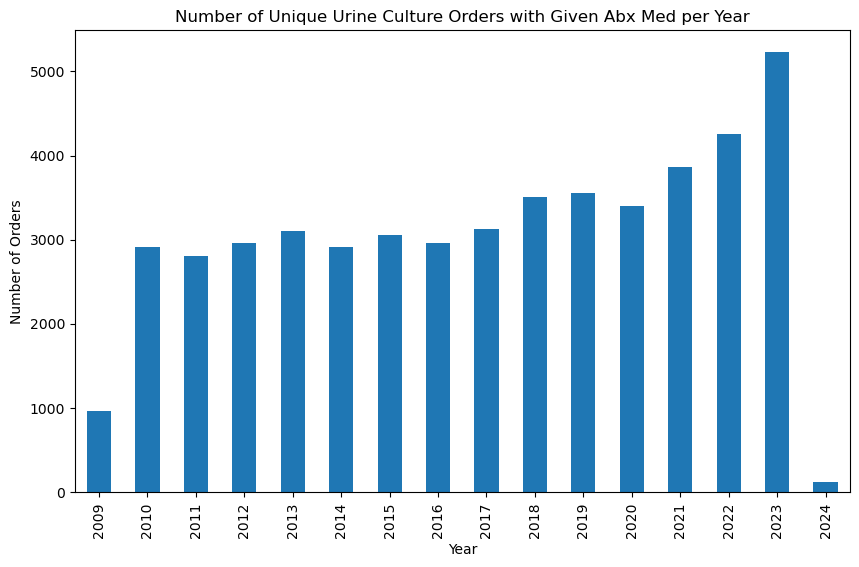

In [48]:
nique_given_final_cohort_inp_ed_only = given_final_cohort_inp_ed_only.drop_duplicates(subset=['anon_id', 'pat_enc_csn_id_coded', 'order_proc_id_coded', 'order_time_jittered_utc'])
nique_given_final_cohort_inp_ed_only["order_time_jittered_utc"].dt.year.value_counts().sort_index().plot(kind='bar', title='Number of Unique Urine Culture Orders with Given Abx Med per Year', xlabel='Year', ylabel='Number of Orders', figsize=(10, 6))

## ⏳ Cleaning the medication name

In [236]:
import ast
import numpy as np

def convert_to_list_and_keep_longest(value):
    try:
        # Convert numpy arrays to lists
        if isinstance(value, np.ndarray):
            value = value.tolist()

        # Already a list? Great.
        if isinstance(value, list) and len(value) > 0:
            str_items = [str(v) for v in value if v not in [None, ""]]
            if str_items:
                return max(str_items, key=len)

        # Fallback — just return original
        return value
    
    except Exception as e:
        print(f"⚠️ Error: {e} — value: {value}")
        raise

# Apply the function to your column
given_final_cohort_inp_ed_only.drop(columns=['hosp_ward_IP', 'hosp_ward_OP', 'hosp_ward_ER', 'hosp_ward_ICU'], inplace=True)
given_final_cohort_inp_ed_only["final_antibiotic"] = given_final_cohort_inp_ed_only["cleaned_antibiotic"].apply(convert_to_list_and_keep_longest).replace(cleaning_mapping)

/var/folders/r3/mc640yrn2_70d_7zvw5cc3q00000gn/T/ipykernel_22422/3317590827.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  given_final_cohort_inp_ed_only.drop(columns=['hosp_ward_IP', 'hosp_ward_OP', 'hosp_ward_ER', 'hosp_ward_ICU'], inplace=True)
/var/folders/r3/mc640yrn2_70d_7zvw5cc3q00000gn/T/ipykernel_22422/3317590827.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  given_final_cohort_inp_ed_only["final_antibiotic"] = given_final_cohort_inp_ed_only["cleaned_antibiotic"].apply(convert_to_list_and_keep_longest).replace(cleaning_mapping)


In [237]:
given_final_cohort_inp_ed_only = given_final_cohort_inp_ed_only.drop_duplicates(subset=['anon_id', 'pat_enc_csn_id_coded', 'order_proc_id_coded', 'order_time_jittered_utc',"result_time_jittered_utc", "final_antibiotic"])

In [146]:
given_final_cohort_inp_ed_only.to_csv('../csv_folder/given_final_cohort_inp_ed_only_adults.csv', index=False)

In [238]:
given_final_cohort_inp_ed_only

,anon_id,pat_enc_csn_id_coded,order_proc_id_coded,order_time_jittered_utc,result_time_jittered_utc,ordering_mode,medication_time,medication_name,order_med_id_coded,medication_action,cleaned_antibiotic,final_antibiotic
0,JC1000063,131011127694,373759075,2010-09-30 16:47:00+00:00,2010-10-02 14:53:00+00:00,Inpatient,2010-10-01 00:30:00+00:00,DOXYCYCLINE HYCLATE 100 MG PO CAPS,373783716,Given,[Doxycycline Hyclate],Doxycycline
3,JC1000063,131011127694,373759075,2010-09-30 16:47:00+00:00,2010-10-02 14:53:00+00:00,Inpatient,2010-10-02 10:40:34+00:00,AMPICILLIN 2 GM IVPB,373855197,Given,[Ampicillin],Ampicillin
4,JC1000063,131011127694,373759075,2010-09-30 16:47:00+00:00,2010-10-02 14:53:00+00:00,Inpatient,2010-10-02 11:58:28+00:00,GENTAMICIN (CUSTOM DOSE) IVPB,373855357,Given,[Gentamicin],Gentamicin
5,JC1000063,131011127694,373759075,2010-09-30 16:47:00+00:00,2010-10-02 14:53:00+00:00,Inpatient,2010-10-02 13:47:49+00:00,CLINDAMYCIN IN D5W 900 MG/50 ML IV PGBK,373855382,Given,[Clindamycin In],Clindamycin
6,JC1000129,131354606122,877003103,2023-04-24 01:28:00+00:00,2023-04-26 01:57:00+00:00,Inpatient,2023-04-23 23:14:00+00:00,CEFEPIME 2 GRAM/20 ML IV PUSH,876966020,Given,[Cefepime],Cefepime
...,...,...,...,...,...,...,...,...,...,...,...,...
334762,JC999841,131042520339,447106081,2014-10-10 06:41:00+00:00,2014-10-12 16:01:00+00:00,Inpatient,2014-10-10 06:31:00+00:00,NITROFURANTOIN MONOHYD/M-CRYST 100 MG PO CAPS,447105727,Given,[Nitrofurantoin],Nitrofurantoin
334763,JC999842,131192863784,500208763,2016-07-16 14:51:00+00:00,2016-07-18 16:13:00+00:00,Inpatient,2016-07-16 18:31:00+00:00,CEFTRIAXONE 1 GRAM/50 ML MINI-BAG PLUS,500216262,Given,[Ceftriaxone],Ceftriaxone
334764,JC999842,131192863784,500208763,2016-07-16 14:51:00+00:00,2016-07-18 16:13:00+00:00,Inpatient,2016-07-16 19:35:00+00:00,METRONIDAZOLE IN NACL (ISO-OS) 500 MG/100 ML I...,500216263,Given,"[Metronidazole In Nacl, Metronidazole]",Metronidazole
334767,JC999842,131192863784,500208763,2016-07-16 14:51:00+00:00,2016-07-18 16:13:00+00:00,Inpatient,2016-07-17 16:29:00+00:00,SULFAMETHOXAZOLE-TRIMETHOPRIM 800-160 MG PO TABS,500183117,Given,"[Sulfamethoxazole-Trimethoprim, Trimethoprim]",Trimethoprim/Sulfamethoxazole


In [239]:
group_counts = given_final_cohort_inp_ed_only.groupby(
    ['anon_id', 'pat_enc_csn_id_coded', 'order_proc_id_coded', 'order_time_jittered_utc']
)['final_antibiotic'].transform('count')

# Filter rows where group count is greater than 1
group_counts_df= given_final_cohort_inp_ed_only[group_counts > 1]
sorted_group_counts_df = group_counts_df.sort_values(by=['anon_id', 'pat_enc_csn_id_coded', 'order_proc_id_coded', 'order_time_jittered_utc'])

print("the unique order number for final_cohort is {}".format(find_unique_orders(given_final_cohort_inp_ed_only)))
print("the unique order number from final cohort that has more than one medication is {}".format(find_unique_orders(sorted_group_counts_df)))

the unique order number for final_cohort is 48737
the unique order number from final cohort that has more than one medication is 17015


In [334]:
# read impliced_susceptibility rules
implied_suspectibility = pd.read_csv('../csv_folder/implied_susceptibility_rules.csv')

# Include implied-susceptibility rules

Step 1: Check for inherent resistance

In [335]:
import re
with_implied_susceptibility_starting_cohort = starting_cohort.copy()
with_implied_susceptibility_starting_cohort["susceptibility_source"] = "original"
# Get unique organisms from implied_susceptibility
bacteria = implied_suspectibility["Organism"].dropna().unique().tolist()

# Create regex pattern and find matches
pattern = '|'.join([re.escape(org) for org in bacteria])
matches = with_implied_susceptibility_starting_cohort["organism"].str.contains(pattern, case=False, na=False)

# Add a new column showing WHICH organism was matched
def find_matched_organism(org_name):
    org_name = str(org_name).upper()
    for bact in bacteria:
        if re.search(re.escape(bact), org_name, re.IGNORECASE):
            return bact
    return None

with_implied_susceptibility_starting_cohort['matched_organism'] \
    = with_implied_susceptibility_starting_cohort['organism'].apply(find_matched_organism)


In [336]:
inherent_resistance = implied_suspectibility[
    implied_suspectibility['Implied_Agent'].isna()
][['Organism', 'Antibiotic']].drop_duplicates()
resistant_to_add = pd.merge(
    with_implied_susceptibility_starting_cohort[['anon_id', 'pat_enc_csn_id_coded', 'order_proc_id_coded',
       'order_time_jittered_utc', 'result_time_jittered_utc', 'ordering_mode',
       'culture_description', 'was_positive', 'organism', "matched_organism"]].drop_duplicates(),
    inherent_resistance,
    left_on='matched_organism',
    right_on='Organism',
    how='inner'
)
resistant_to_add = resistant_to_add.rename(columns={'Antibiotic': 'antibiotic'})
resistant_to_add['susceptibility'] = 'Resistant'
resistant_to_add['susceptibility_source'] = 'inherent_resistance'
cols_to_keep = with_implied_susceptibility_starting_cohort.columns
added_resistant_cohort = (pd.concat([
    with_implied_susceptibility_starting_cohort,
    resistant_to_add[cols_to_keep]
], ignore_index=True))\
    .drop_duplicates(subset=['anon_id', 'pat_enc_csn_id_coded', 'order_proc_id_coded', 
            'organism', 'antibiotic', 'susceptibility'], keep='first')\
    .sort_values(by=['anon_id', 'pat_enc_csn_id_coded', 'order_proc_id_coded', 'order_time_jittered_utc'])# Keeps our new resistant records if duplicates exist

In [236]:
# duplicate_check = added_resistant_cohort.duplicated(
#     subset=['anon_id', 'pat_enc_csn_id_coded', 'order_proc_id_coded', 
#             'organism', 'antibiotic', 'susceptibility'],
#     keep=False  # Mark all duplicates as True
# )

# # Step 2: Create a separate dataframe with just duplicates
# duplicates_df = added_resistant_cohort[duplicate_check].sort_values(
#     by=['anon_id', 'pat_enc_csn_id_coded', 'order_proc_id_coded', 
#         'organism', 'antibiotic', 'susceptibility']
# )

Step 2: Check for implied susceptibility

In [337]:
implied_agent_rules = implied_suspectibility[
    implied_suspectibility['Implied_Agent'].notna()
][['Organism', 'Antibiotic', 'Implied_Agent']].drop_duplicates()
implied_to_process = pd.merge(
    added_resistant_cohort.drop(columns = ['susceptibility_source']),
    implied_agent_rules,
    left_on=['matched_organism', 'antibiotic'],
    right_on=['Organism', 'Implied_Agent'],
    how='inner'
).rename(columns={'antibiotic': 'antibiotic_to_drop', 'Antibiotic': 'antibiotic'}).drop(columns =['antibiotic_to_drop', 'Organism', 'Implied_Agent'])
implied_to_process['susceptibility_source'] = 'implied'
cols_to_keep = added_resistant_cohort.columns
final_implied_cohort = (pd.concat([
    added_resistant_cohort,
    implied_to_process[cols_to_keep]
], ignore_index=True)).sort_values(by=['anon_id', 'pat_enc_csn_id_coded', 'order_proc_id_coded', 'order_time_jittered_utc'])\
    .drop_duplicates(subset=['anon_id', 'pat_enc_csn_id_coded', 'order_proc_id_coded', 
            'organism', 'antibiotic', 'susceptibility'], keep='first')

In [338]:
find_unique_orders(final_implied_cohort)

480007

In [244]:
# condition = (final_implied_cohort["was_positive"] == 1) & (final_implied_cohort["organism"].isna())
# final_implied_cohort = final_implied_cohort[~condition]
# find_unique_orders(final_implied_cohort)

479615

In [339]:
final_implied_cohort.to_csv('../csv_folder/final_implied_cohort.csv', index=False)

In [340]:
merged_culture_med = given_final_cohort_inp_ed_only.drop(columns = ["cleaned_antibiotic"]).merge(final_implied_cohort, on=['anon_id', 'pat_enc_csn_id_coded', 'order_proc_id_coded', 'order_time_jittered_utc', 'result_time_jittered_utc'], how='inner')

In [281]:
# merged_culture_med.to_csv('../csv_folder/merged_culture_med_analysis.csv', index=False)

In [341]:
print("while the unique culture order is {}, the number of medication to evaluate is {}".format(find_unique_orders(given_final_cohort_inp_ed_only), len(given_final_cohort_inp_ed_only)))

while the unique culture order is 48737, the number of medication to evaluate is 74991


In [342]:
print("the number of unique medications to be evaluated is {}"\
      .format(len(given_final_cohort_inp_ed_only.groupby(['anon_id', 'pat_enc_csn_id_coded', 'order_proc_id_coded', 'order_time_jittered_utc', "final_antibiotic"]))))

the number of unique medications to be evaluated is 74991


In [373]:
# negative rate
10067/18497, 8430/18497

(0.5442504189868628, 0.4557495810131373)

In [ ]:
# Incorporate antibiotic ranking to  both prescribe and tested antibioti

In [343]:
%%bigquery --use_rest_api aim_4_antibiotic_ranking
select * from som-nero-phi-jonc101.antimicrobial_stewardship_sandy_copy.aim_4_antibiotic_ranking

Query is running:   0%|          |

Downloading:   0%|          |

In [344]:
with_prescribed_abx_rank_df = merged_culture_med.merge(aim_4_antibiotic_ranking, \
                                   left_on=['final_antibiotic'], right_on=['antibiotic_agent'], how='left')\
                                    .rename(columns={'spectrum_ranking': 'presciribed_antibiotic_rank'})\
                                    .drop(columns = ['antibiotic_agent', 'spectrum'])
with_tested_and_prescribed_abx_rank_df = with_prescribed_abx_rank_df.merge(aim_4_antibiotic_ranking, \
                                   left_on=['antibiotic'], right_on=['antibiotic_agent'], how='left')\
                                    .rename(columns={'spectrum_ranking': 'tested_antibiotic_rank',
                                                     'ordering_mode_x': 'ordering_mode'})\
                                        .drop(columns = ['antibiotic_agent', 'spectrum','ordering_mode_y'])

In [345]:
negative_cohort = with_tested_and_prescribed_abx_rank_df[with_tested_and_prescribed_abx_rank_df["was_positive"] == 0]
positive_cohort = with_tested_and_prescribed_abx_rank_df[with_tested_and_prescribed_abx_rank_df["was_positive"] == 1]
# print("the unique order number for negative cohort is {}".format(find_unique_orders(negative_cohort)))
# print("the unique order number for positive cohort is {}".format(find_unique_orders(positive_cohort)))

In [346]:
len(negative_cohort.groupby(['anon_id', 'pat_enc_csn_id_coded', 'order_proc_id_coded', 'order_time_jittered_utc', "final_antibiotic"]))

42840

In [347]:
len(positive_cohort.groupby(['anon_id', 'pat_enc_csn_id_coded', 'order_proc_id_coded', 'order_time_jittered_utc', "final_antibiotic"]))

32151

In [348]:
42840 + 32151

74991

In [357]:
with_tested_and_prescribed_abx_rank_df.groupby(["anon_id", "pat_enc_csn_id_coded", "order_proc_id_coded", 
        "order_time_jittered_utc", "result_time_jittered_utc","final_antibiotic"])[["presciribed_antibiotic_rank"]].min().reset_index()["presciribed_antibiotic_rank"].value_counts().sort_index()
# negative_cohort["final_antibiotic"].value_counts().sort_index()

presciribed_antibiotic_rank
1      7469
2     12713
3     36052
4      8636
5      8238
6       773
99     1110
Name: count, dtype: Int64

In [367]:
7469 + 12713 +36052 + 8636 +8238+773+1110 - 1110

73881

In [352]:
def evaluate_antibiotic_appropriateness(group):
    # Get all tested antibiotics with their susceptibility and ranking
    tested_abx = group[['antibiotic', 'susceptibility', 'tested_antibiotic_rank']].drop_duplicates()
    
    # Get the prescribed antibiotic
    prescribed_abx = group['final_antibiotic'].iloc[0]
    prescribed_rank = group['presciribed_antibiotic_rank'].iloc[0]
    
    # Scenario 1: Appropriate (susceptible and minimal rank)
    susceptible_tested = tested_abx[tested_abx['susceptibility'] == 'Susceptible']
    min_rank = susceptible_tested['tested_antibiotic_rank'].min()
    try:
        min_tested_susceptible_abx = susceptible_tested[susceptible_tested['tested_antibiotic_rank'] == min_rank]['antibiotic'].iloc[0]
    except IndexError:
        min_tested_susceptible_abx = None
    if not susceptible_tested.empty:
        # min_rank = susceptible_tested['tested_antibiotic_rank'].min()
        if prescribed_abx in susceptible_tested['antibiotic'].values:
            if prescribed_rank == min_rank:
                return pd.Series({
                    'scenario': 'appropriate',
                    'ranking_diff': 0,
                    'min_susceptible_test_rank': min_rank,
                    'min_tested_susceptible_abx': prescribed_abx,
                    'prescribed_rank': prescribed_rank
                })
    
    # Scenario 2: Too broad (susceptible but not minimal rank)
            else:
                return pd.Series({
                    'scenario': 'too_broad',
                    'ranking_diff': prescribed_rank - min_rank,
                    'min_susceptible_test_rank': min_rank,
                    'min_tested_susceptible_abx': min_tested_susceptible_abx,
                    'prescribed_rank': prescribed_rank
                })
    
    # Scenario 3: Resistant (non-susceptible)
    if prescribed_abx in group['antibiotic'].values:
        prescribed_susceptibility = group[group['antibiotic'] == prescribed_abx]['susceptibility'].iloc[0]
        
        if prescribed_susceptibility != 'Susceptible':
            return pd.Series({
                'scenario': 'resistant',
                'ranking_diff': "N/A",
                'min_susceptible_test_rank': susceptible_tested['tested_antibiotic_rank'].min() if not susceptible_tested.empty else None,
                'min_tested_susceptible_abx': min_tested_susceptible_abx,
                'prescribed_rank': prescribed_rank
            })
    
    # Scenario 4: Not performed
    return pd.Series({
        'scenario': 'not_performed',
        'ranking_diff': "N/A",
        'min_susceptible_test_rank': susceptible_tested['tested_antibiotic_rank'].min() if not susceptible_tested.empty else None,
        'min_tested_susceptible_abx': min_tested_susceptible_abx,
        'prescribed_rank': prescribed_rank
    })

# Apply to each group
results = positive_cohort.groupby([
    "anon_id", "pat_enc_csn_id_coded", "order_proc_id_coded", 
    "order_time_jittered_utc", "result_time_jittered_utc", "final_antibiotic"
]).apply(evaluate_antibiotic_appropriateness).reset_index()

# Merge results back with original data
final_cohort_with_evaluation = positive_cohort.merge(
    results,
    on=["anon_id", "pat_enc_csn_id_coded", "order_proc_id_coded", 
        "order_time_jittered_utc", "result_time_jittered_utc", "final_antibiotic"]
)

In [353]:
results

,anon_id,pat_enc_csn_id_coded,order_proc_id_coded,order_time_jittered_utc,result_time_jittered_utc,final_antibiotic,scenario,ranking_diff,min_susceptible_test_rank,min_tested_susceptible_abx,prescribed_rank
0,JC1000129,131359337847,894465321,2023-07-12 23:05:00+00:00,2023-07-17 23:46:00+00:00,Ceftriaxone,too_broad,2,1.0,Cefazolin,3
1,JC1000129,131359337847,894465321,2023-07-12 23:05:00+00:00,2023-07-17 23:46:00+00:00,Ertapenem,too_broad,4,1.0,Cefazolin,5
2,JC1000159,131233687107,528101351,2017-06-25 18:22:00+00:00,2017-06-27 19:56:00+00:00,Ceftriaxone,too_broad,2,1.0,Ampicillin,3
3,JC1000159,131233687107,528101351,2017-06-25 18:22:00+00:00,2017-06-27 19:56:00+00:00,Ciprofloxacin,too_broad,2,1.0,Ampicillin,3
4,JC1000441,131016140612,392035082,2011-11-10 22:20:00+00:00,2011-11-13 05:38:00+00:00,Nitrofurantoin,too_broad,1,1.0,Cefazolin,2
...,...,...,...,...,...,...,...,...,...,...,...
32146,JC999190,131363310674,908354797,2023-10-19 09:32:00+00:00,2023-10-22 17:36:00+00:00,Amoxicillin/Clavulanic Acid,too_broad,1,1.0,Ampicillin,2
32147,JC999374,131024874435,420600992,2013-05-31 15:31:00+00:00,2013-06-02 16:08:00+00:00,Ciprofloxacin,too_broad,1,2.0,Nitrofurantoin,3
32148,JC999590,131022787414,414244926,2013-02-04 01:57:00+00:00,2013-02-06 07:08:00+00:00,Aztreonam,not_performed,N/A,1.0,Cefazolin,6
32149,JC999590,131022787414,414244926,2013-02-04 01:57:00+00:00,2013-02-06 07:08:00+00:00,Levofloxacin,too_broad,2,1.0,Cefazolin,3


In [359]:
results["scenario"].value_counts()

scenario
too_broad        16542
not_performed     9192
resistant         5408
appropriate       1009
Name: count, dtype: int64

In [368]:
1009+16542+5408+42840+9192 - 1110

73881

In [369]:
9192 - 1110

8082

In [370]:
1009+16542+5408+42840+8082

73881

In [356]:
len(negative_cohort.groupby(
    ["anon_id", "pat_enc_csn_id_coded", "order_proc_id_coded", 
    "order_time_jittered_utc", "result_time_jittered_utc", "final_antibiotic"]))

42840

In [286]:
final_cohort_with_evaluation.drop(columns = ['medication_action', 'ordering_mode', 'culture_description'], inplace=True)

In [162]:
# final_cohort_with_evaluation.drop(columns = ['prescribed_rank'], inplace=True)

In [371]:
# Filter out rows where scenario is 'not_performed'
not_performed_df = final_cohort_with_evaluation[final_cohort_with_evaluation["scenario"] == "not_performed"]

# Select only the columns you care about and drop duplicates to get unique pairs
unique_pairs = not_performed_df[["organism","final_antibiotic"]].drop_duplicates()

# Count occurrences of each antibiotic-organism pair
pair_counts = not_performed_df.drop_duplicates(subset= ["anon_id", "pat_enc_csn_id_coded", "order_proc_id_coded", 
        "order_time_jittered_utc", "result_time_jittered_utc","final_antibiotic", "organism"]).groupby(["final_antibiotic", "organism"]).size().reset_index(name="count").sort_values(by="count", ascending=False)

# Display the result

# Display the result
not_performed_df.to_csv('../csv_folder/not_performed_df.csv', index=False)
unique_pairs.to_csv('../csv_folder/unique_pairs.csv', index=False)
pair_counts.to_csv('../csv_folder/unique_pair_counts.csv', index=False)

In [303]:
positive_cohort.groupby(["anon_id", "pat_enc_csn_id_coded", "order_proc_id_coded", 
        "order_time_jittered_utc", "result_time_jittered_utc","final_antibiotic"])[["presciribed_antibiotic_rank"]].max().reset_index()["presciribed_antibiotic_rank"].value_counts().sort_index()
# negative_cohort["final_antibiotic"].value_counts().sort_index()

presciribed_antibiotic_rank
1      3246
2      5304
3     16981
4      2792
5      3050
6       371
99      407
Name: count, dtype: Int64

In [379]:
(positive_cohort.groupby(["anon_id", "pat_enc_csn_id_coded", "order_proc_id_coded", 
        "order_time_jittered_utc", "result_time_jittered_utc","final_antibiotic"]))["presciribed_antibiotic_rank"].min().reset_index()

,anon_id,pat_enc_csn_id_coded,order_proc_id_coded,order_time_jittered_utc,result_time_jittered_utc,final_antibiotic,presciribed_antibiotic_rank
0,JC1000129,131359337847,894465321,2023-07-12 23:05:00+00:00,2023-07-17 23:46:00+00:00,Ceftriaxone,3
1,JC1000129,131359337847,894465321,2023-07-12 23:05:00+00:00,2023-07-17 23:46:00+00:00,Ertapenem,5
2,JC1000159,131233687107,528101351,2017-06-25 18:22:00+00:00,2017-06-27 19:56:00+00:00,Ceftriaxone,3
3,JC1000159,131233687107,528101351,2017-06-25 18:22:00+00:00,2017-06-27 19:56:00+00:00,Ciprofloxacin,3
4,JC1000441,131016140612,392035082,2011-11-10 22:20:00+00:00,2011-11-13 05:38:00+00:00,Nitrofurantoin,2
...,...,...,...,...,...,...,...
32146,JC999190,131363310674,908354797,2023-10-19 09:32:00+00:00,2023-10-22 17:36:00+00:00,Amoxicillin/Clavulanic Acid,2
32147,JC999374,131024874435,420600992,2013-05-31 15:31:00+00:00,2013-06-02 16:08:00+00:00,Ciprofloxacin,3
32148,JC999590,131022787414,414244926,2013-02-04 01:57:00+00:00,2013-02-06 07:08:00+00:00,Aztreonam,6
32149,JC999590,131022787414,414244926,2013-02-04 01:57:00+00:00,2013-02-06 07:08:00+00:00,Levofloxacin,3


In [378]:
(positive_cohort.groupby(["anon_id", "pat_enc_csn_id_coded", "order_proc_id_coded", 
        "order_time_jittered_utc", "result_time_jittered_utc","final_antibiotic"]))["presciribed_antibiotic_rank"].max().reset_index()

,anon_id,pat_enc_csn_id_coded,order_proc_id_coded,order_time_jittered_utc,result_time_jittered_utc,final_antibiotic,presciribed_antibiotic_rank
0,JC1000129,131359337847,894465321,2023-07-12 23:05:00+00:00,2023-07-17 23:46:00+00:00,Ceftriaxone,3
1,JC1000129,131359337847,894465321,2023-07-12 23:05:00+00:00,2023-07-17 23:46:00+00:00,Ertapenem,5
2,JC1000159,131233687107,528101351,2017-06-25 18:22:00+00:00,2017-06-27 19:56:00+00:00,Ceftriaxone,3
3,JC1000159,131233687107,528101351,2017-06-25 18:22:00+00:00,2017-06-27 19:56:00+00:00,Ciprofloxacin,3
4,JC1000441,131016140612,392035082,2011-11-10 22:20:00+00:00,2011-11-13 05:38:00+00:00,Nitrofurantoin,2
...,...,...,...,...,...,...,...
32146,JC999190,131363310674,908354797,2023-10-19 09:32:00+00:00,2023-10-22 17:36:00+00:00,Amoxicillin/Clavulanic Acid,2
32147,JC999374,131024874435,420600992,2013-05-31 15:31:00+00:00,2013-06-02 16:08:00+00:00,Ciprofloxacin,3
32148,JC999590,131022787414,414244926,2013-02-04 01:57:00+00:00,2013-02-06 07:08:00+00:00,Aztreonam,6
32149,JC999590,131022787414,414244926,2013-02-04 01:57:00+00:00,2013-02-06 07:08:00+00:00,Levofloxacin,3


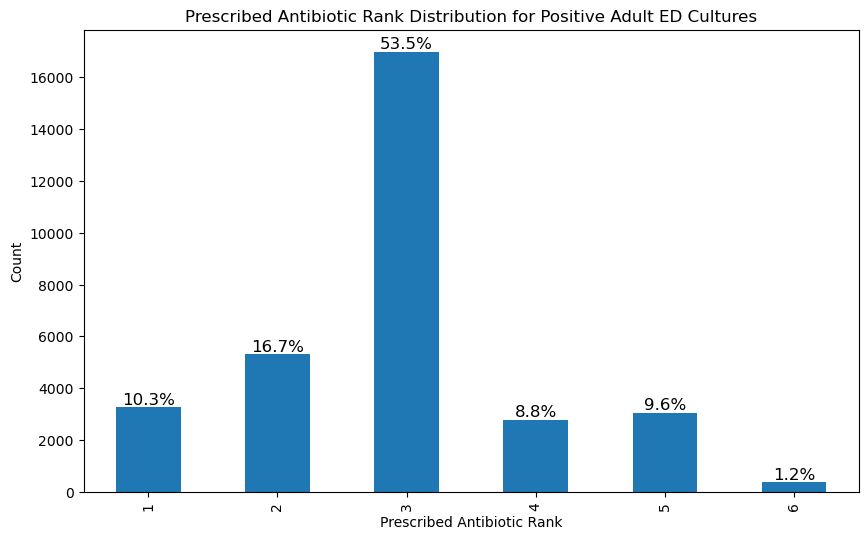

In [395]:
import matplotlib.pyplot as plt

# Plot the bar chart
results_new = results[results["prescribed_rank"]!= 99]
ax = results_new["prescribed_rank"].value_counts().sort_index().plot(
    kind='bar', 
    title='Prescribed Antibiotic Rank Distribution for Positive Adult ED Cultures',
    xlabel='Prescribed Antibiotic Rank', 
    ylabel='Count', 
    figsize=(10, 6)
)

# Add percentages on top of each bar
total = results_new["prescribed_rank"].value_counts().sum()
for p in ax.patches:
    percentage = f'{(p.get_height() / total) * 100:.1f}%'
    ax.annotate(percentage, 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom', fontsize=12)

plt.show()

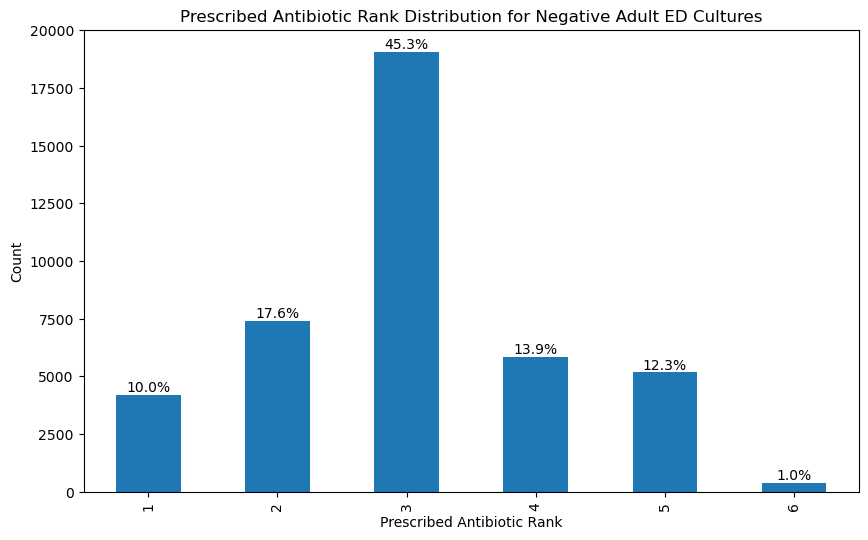

In [394]:
a = negative_cohort.groupby(["anon_id", "pat_enc_csn_id_coded", "order_proc_id_coded", 
        "order_time_jittered_utc", "result_time_jittered_utc","final_antibiotic"])[["presciribed_antibiotic_rank"]].max().reset_index()["presciribed_antibiotic_rank"].value_counts().sort_index()


a = a[a.index != 99]

# Calculate percentages
total = a.sum()
percentages = (a / total) * 100

# Plot the bar chart
ax = a.plot(kind='bar', title='Prescribed Antibiotic Rank Distribution for Negative Adult ED Cultures', 
                        xlabel='Prescribed Antibiotic Rank' , ylabel='Count', figsize=(10, 6))

# Add percentages on top of each bar
for p, percentage in zip(ax.patches, percentages):
        ax.annotate(f'{percentage:.1f}%', 
                                (p.get_x() + p.get_width() / 2., p.get_height()), 
                                ha='center', va='bottom', fontsize=10)

plt.show()

In [381]:
positive_cohort.groupby(["anon_id", "pat_enc_csn_id_coded", "order_proc_id_coded", 
        "order_time_jittered_utc", "result_time_jittered_utc","final_antibiotic"])[["presciribed_antibiotic_rank"]].min().reset_index()["presciribed_antibiotic_rank"].value_counts().sort_index()
# negative_cohort["final_antibiotic"].value_counts().sort_index()

presciribed_antibiotic_rank
1      3258
2      5304
3     16990
4      2792
5      3050
6       371
99      386
Name: count, dtype: Int64

In [290]:
import random
# 'JC802169', 131026681314, 425333288
grouped = final_cohort_with_evaluation[final_cohort_with_evaluation["scenario"] == "not_performed"].groupby([
    "anon_id", "pat_enc_csn_id_coded", "order_proc_id_coded", 
    "order_time_jittered_utc", "result_time_jittered_utc", "final_antibiotic"
])
# Randomly pick a group
random_group = random.choice(list(grouped.groups.keys()))
print(f"Randomly picked group: {random_group}")
# Build a boolean filter from the group key
filt = (
    (final_cohort_with_evaluation["anon_id"] == random_group[0]) &
    (final_cohort_with_evaluation["pat_enc_csn_id_coded"] == random_group[1]) &
    (final_cohort_with_evaluation["order_proc_id_coded"] == random_group[2]) &
    (final_cohort_with_evaluation["order_time_jittered_utc"] == random_group[3]) &
    (final_cohort_with_evaluation["result_time_jittered_utc"] == random_group[4]) &
    (final_cohort_with_evaluation["final_antibiotic"] == random_group[5])
)
final_cohort_with_evaluation[filt]


Randomly picked group: ('JC732372', 131243323769, 546850574, Timestamp('2018-01-29 21:05:00+0000', tz='UTC'), Timestamp('2018-01-31 17:02:00+0000', tz='UTC'), 'Metronidazole')


,anon_id,pat_enc_csn_id_coded,order_proc_id_coded,order_time_jittered_utc,result_time_jittered_utc,medication_time,medication_name,order_med_id_coded,final_antibiotic,was_positive,organism,antibiotic,susceptibility,susceptibility_source,matched_organism,presciribed_antibiotic_rank,tested_antibiotic_rank,scenario,ranking_diff,min_susceptible_test_rank
568558,JC732372,131243323769,546850574,2018-01-29 21:05:00+00:00,2018-01-31 17:02:00+00:00,2018-01-30 00:36:00+00:00,METRONIDAZOLE IN NACL (ISO-OS) 500 MG/100 ML I...,546853819,Metronidazole,1,ESCHERICHIA COLI,Ceftazidime,Resistant,original,ESCHERICHIA COLI,2,3,not_performed,NaN,2.0
568559,JC732372,131243323769,546850574,2018-01-29 21:05:00+00:00,2018-01-31 17:02:00+00:00,2018-01-30 00:36:00+00:00,METRONIDAZOLE IN NACL (ISO-OS) 500 MG/100 ML I...,546853819,Metronidazole,1,ESCHERICHIA COLI,Ertapenem,Susceptible,original,ESCHERICHIA COLI,2,5,not_performed,NaN,2.0
568560,JC732372,131243323769,546850574,2018-01-29 21:05:00+00:00,2018-01-31 17:02:00+00:00,2018-01-30 00:36:00+00:00,METRONIDAZOLE IN NACL (ISO-OS) 500 MG/100 ML I...,546853819,Metronidazole,1,ESCHERICHIA COLI,Trimethoprim/Sulfamethoxazole,Susceptible,original,ESCHERICHIA COLI,2,2,not_performed,NaN,2.0
568561,JC732372,131243323769,546850574,2018-01-29 21:05:00+00:00,2018-01-31 17:02:00+00:00,2018-01-30 00:36:00+00:00,METRONIDAZOLE IN NACL (ISO-OS) 500 MG/100 ML I...,546853819,Metronidazole,1,ESCHERICHIA COLI,Amoxicillin/Clavulanic Acid,Intermediate,original,ESCHERICHIA COLI,2,2,not_performed,NaN,2.0
568562,JC732372,131243323769,546850574,2018-01-29 21:05:00+00:00,2018-01-31 17:02:00+00:00,2018-01-30 00:36:00+00:00,METRONIDAZOLE IN NACL (ISO-OS) 500 MG/100 ML I...,546853819,Metronidazole,1,ESCHERICHIA COLI,Ciprofloxacin,Resistant,original,ESCHERICHIA COLI,2,3,not_performed,NaN,2.0
568563,JC732372,131243323769,546850574,2018-01-29 21:05:00+00:00,2018-01-31 17:02:00+00:00,2018-01-30 00:36:00+00:00,METRONIDAZOLE IN NACL (ISO-OS) 500 MG/100 ML I...,546853819,Metronidazole,1,ESCHERICHIA COLI,Meropenem,Susceptible,original,ESCHERICHIA COLI,2,5,not_performed,NaN,2.0
568564,JC732372,131243323769,546850574,2018-01-29 21:05:00+00:00,2018-01-31 17:02:00+00:00,2018-01-30 00:36:00+00:00,METRONIDAZOLE IN NACL (ISO-OS) 500 MG/100 ML I...,546853819,Metronidazole,1,ESCHERICHIA COLI,Tobramycin,Susceptible,original,ESCHERICHIA COLI,2,5,not_performed,NaN,2.0
568565,JC732372,131243323769,546850574,2018-01-29 21:05:00+00:00,2018-01-31 17:02:00+00:00,2018-01-30 00:36:00+00:00,METRONIDAZOLE IN NACL (ISO-OS) 500 MG/100 ML I...,546853819,Metronidazole,1,ESCHERICHIA COLI,Amikacin,Susceptible,original,ESCHERICHIA COLI,2,2,not_performed,NaN,2.0
568566,JC732372,131243323769,546850574,2018-01-29 21:05:00+00:00,2018-01-31 17:02:00+00:00,2018-01-30 00:36:00+00:00,METRONIDAZOLE IN NACL (ISO-OS) 500 MG/100 ML I...,546853819,Metronidazole,1,ESCHERICHIA COLI,Piperacillin/Tazobactam,Susceptible,original,ESCHERICHIA COLI,2,4,not_performed,NaN,2.0
568567,JC732372,131243323769,546850574,2018-01-29 21:05:00+00:00,2018-01-31 17:02:00+00:00,2018-01-30 00:36:00+00:00,METRONIDAZOLE IN NACL (ISO-OS) 500 MG/100 ML I...,546853819,Metronidazole,1,ESCHERICHIA COLI,Cefoxitin,Resistant,original,ESCHERICHIA COLI,2,3,not_performed,NaN,2.0


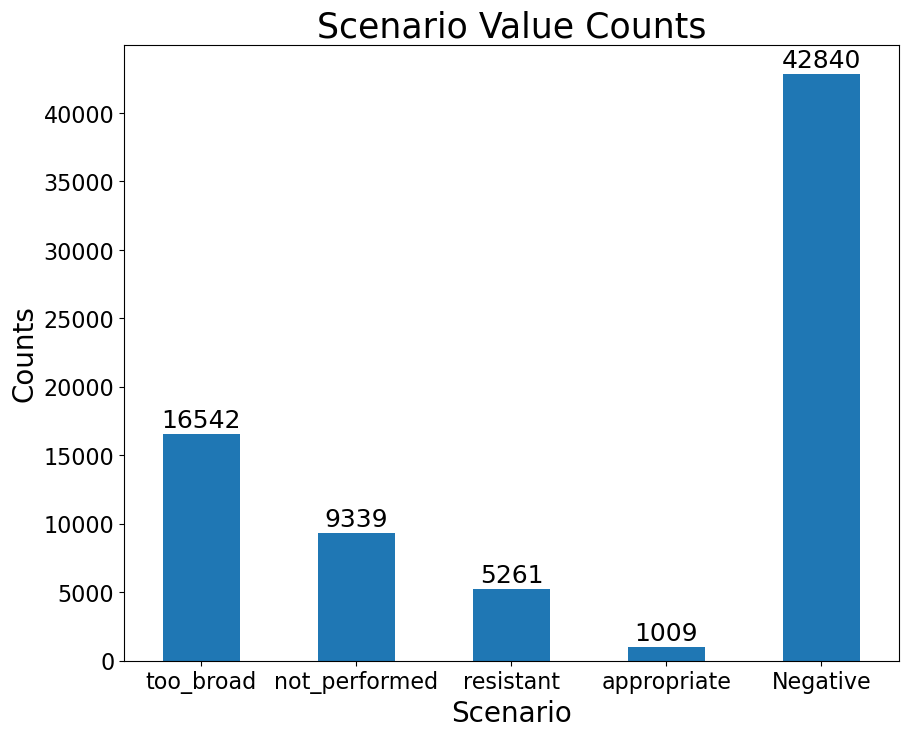

In [292]:
plt.figure(figsize=(10, 8))
# 1) Get the scenario counts as a Series
scenario_counts = results["scenario"].value_counts()

# 2) Append your extra row
scenario_counts.loc["Negative"] = len(negative_cohort.groupby(
    ["anon_id", "pat_enc_csn_id_coded", "order_proc_id_coded", 
    "order_time_jittered_utc", "result_time_jittered_utc", "final_antibiotic"]
))

# 3) Plot in one step
ax = scenario_counts.plot(
    kind='bar',
    title='Scenario Value Counts',
    xlabel='Scenario',
    ylabel='Counts',
    rot=0,  # rotate x-labels if desired
    fontsize=16, # increase the font size for labels
)
ax.set_title('Scenario Value Counts', fontsize=25)
ax.set_xlabel("Scenario", fontsize=20)
ax.set_ylabel("Counts", fontsize=20)
# Add count numbers on top of each bar
for i, count in enumerate(scenario_counts):
    ax.text(i, count + 100, str(count), ha='center', va='bottom', fontsize=18)

plt.show()

/var/folders/r3/mc640yrn2_70d_7zvw5cc3q00000gn/T/ipykernel_22422/3388665088.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  percentage = scenario_percentages[i]


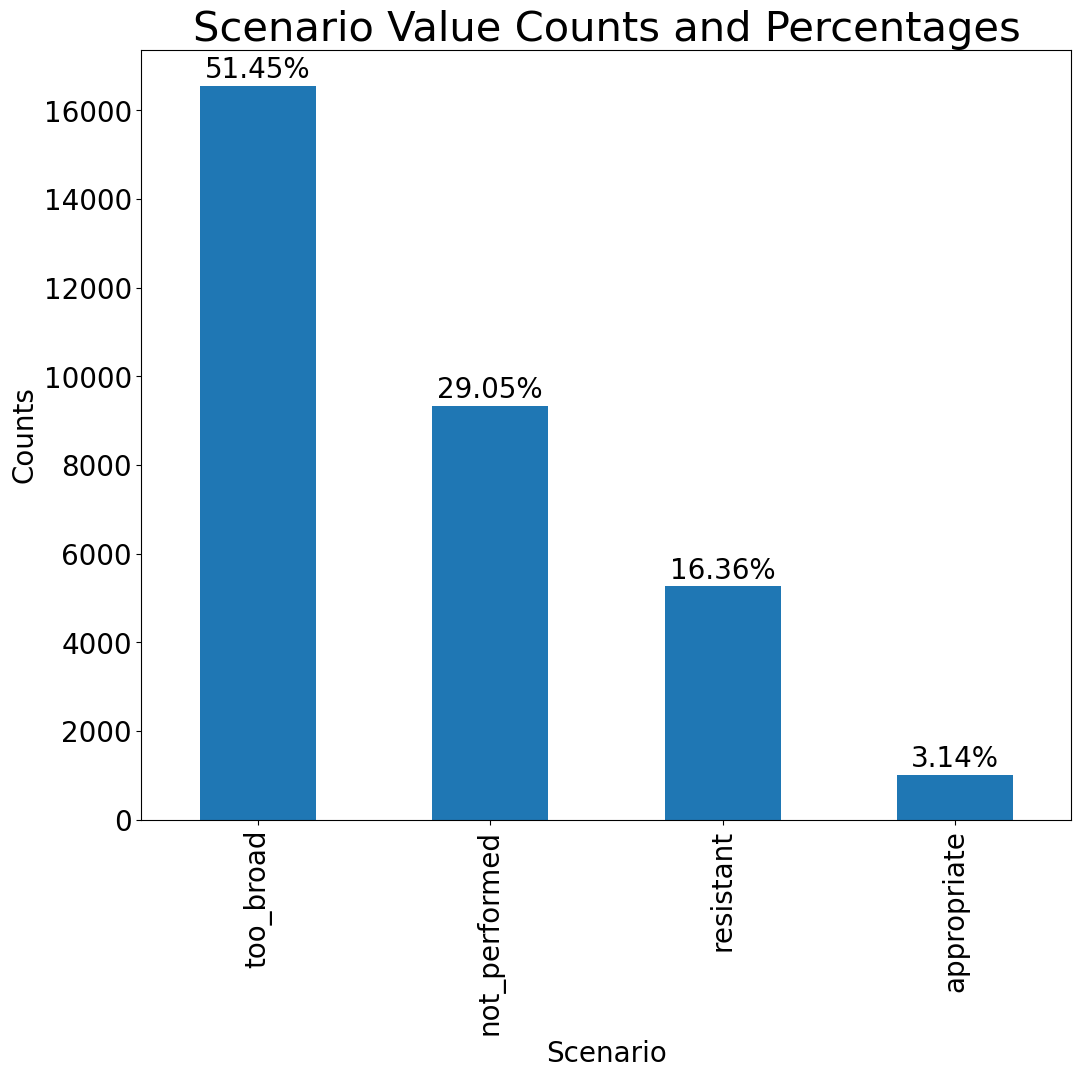

In [293]:
plt.figure(figsize=(12, 10))
# Plot the existing scenario value counts
# Calculate the percentage
scenario_counts = results["scenario"].value_counts()
scenario_percentages = (scenario_counts / scenario_counts.sum()) * 100

# Plot the counts
ax = scenario_counts.plot(kind='bar', title='Scenario Value Counts and Percentages', xlabel='Scenario', ylabel='Counts', fontsize=20)
ax.set_title('Scenario Value Counts and Percentages', fontsize=30)
ax.set_xlabel("Scenario", fontsize=20)
ax.set_ylabel("Counts", fontsize=20)
# Add percentages on top of the bars
for i, count in enumerate(scenario_counts):
    percentage = scenario_percentages[i]
    ax.text(i, count + 50, f'{percentage:.2f}%', ha='center', va='bottom', fontsize=20)
# ax = results["scenario"].value_counts().plot(kind='bar', title='Scenario Value Counts', xlabel='Scenario', ylabel='Counts')


# Show the plot
plt.show()

In [294]:
results[results["scenario"] == "too_broad"]["ranking_diff"].value_counts().sort_index()

ranking_diff
1.0     4041
2.0    10244
3.0     1770
4.0      441
5.0       46
Name: count, dtype: int64

In [325]:
too_broad_df= results[results["scenario"] == "too_broad"]

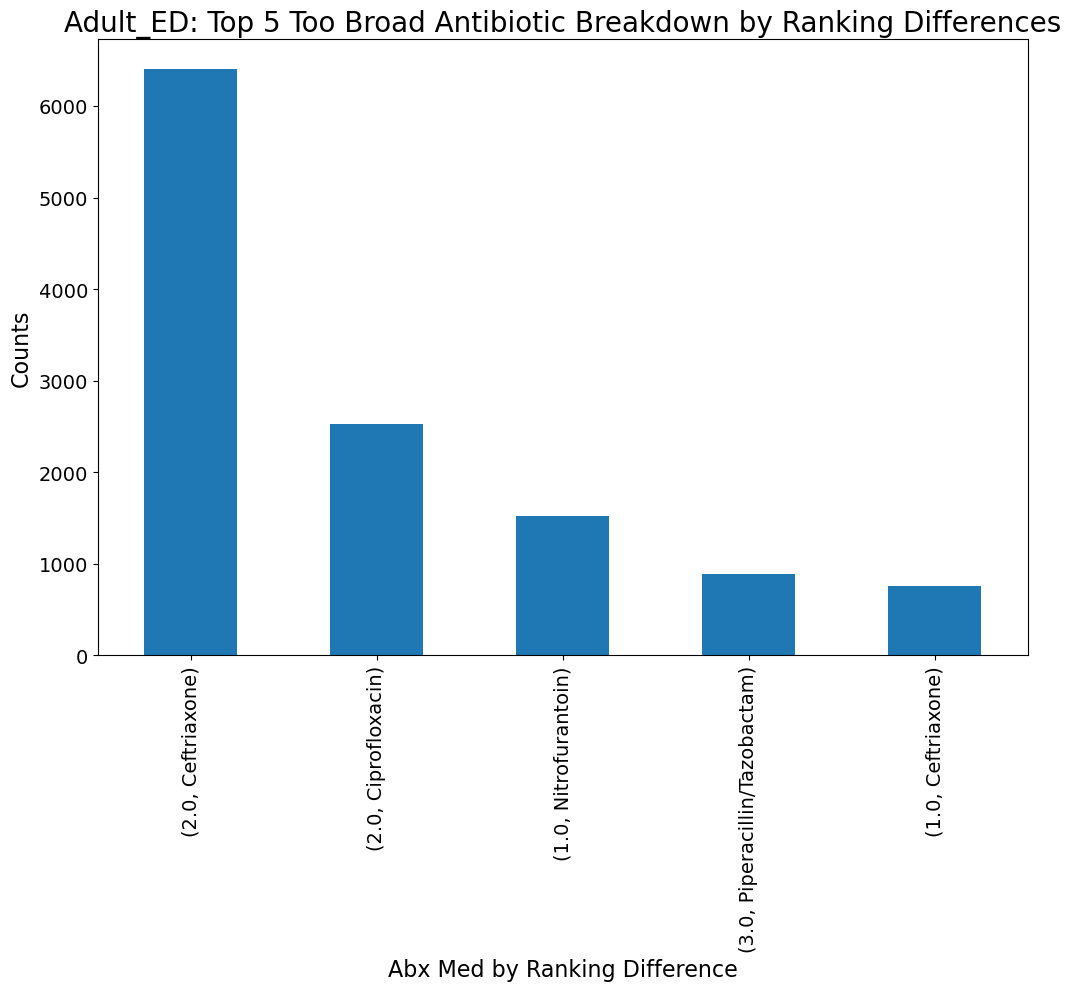

In [333]:
import matplotlib.pyplot as plt

too_broad_df = results[results["scenario"] == "too_broad"]

# Group by ranking_diff and final_antibiotic, then sort and get the top 5
top_5 = (
    too_broad_df.groupby(["ranking_diff"])["final_antibiotic"]
    .value_counts()
    .sort_values(ascending=False)
    .head(5)
)

# Plot the top 5
ax = top_5.plot(
    kind='bar',
    figsize=(12, 8),
    fontsize=14  # Adjust font size for tick labels
)

# Customize title and axis labels with larger font sizes
ax.set_title('Adult_ED: Top 5 Too Broad Antibiotic Breakdown by Ranking Differences', fontsize=20)
ax.set_xlabel('Abx Med by Ranking Difference', fontsize=16)
ax.set_ylabel('Counts', fontsize=16)

# Show the plot
plt.show()

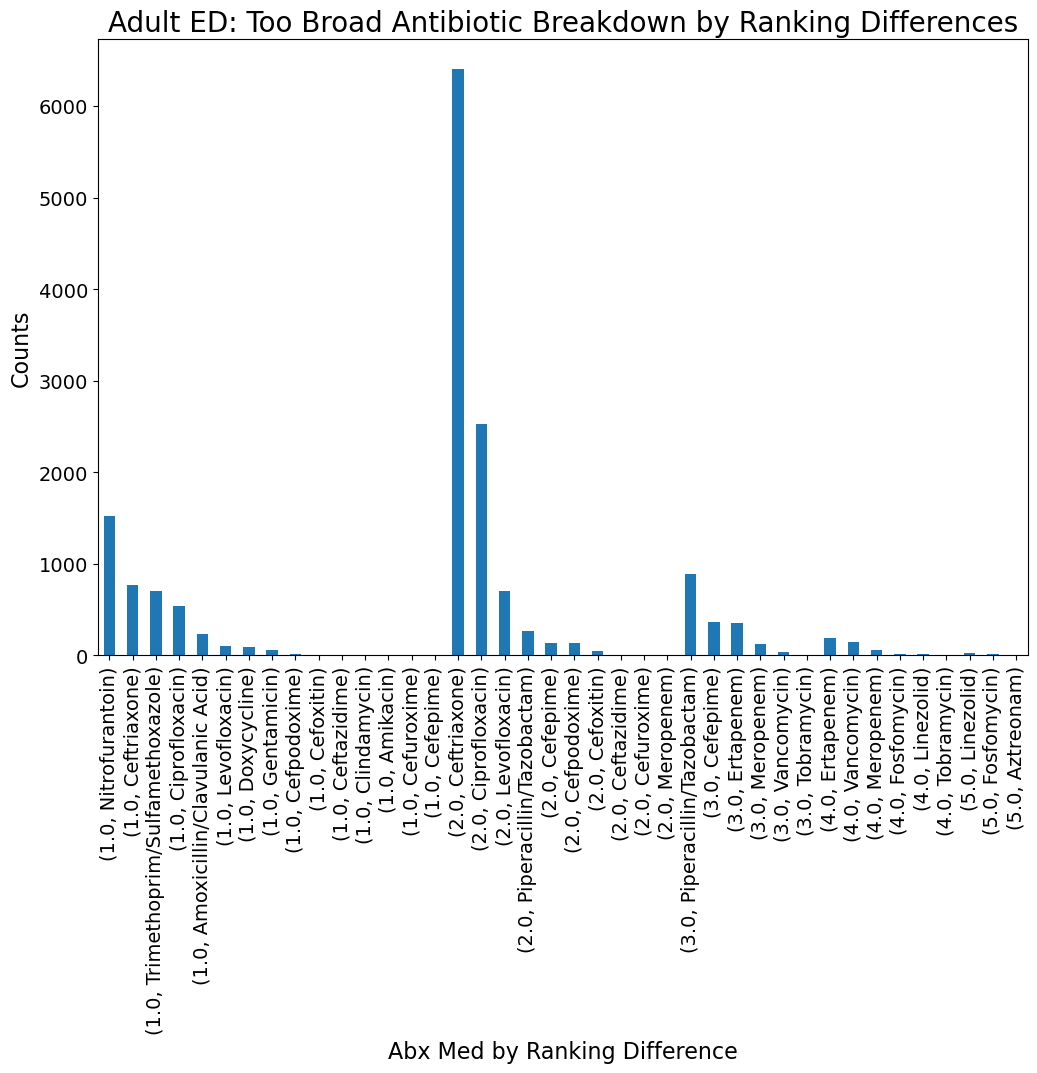

In [332]:
import matplotlib.pyplot as plt

ax = too_broad_df.groupby(["ranking_diff"])["final_antibiotic"].value_counts().plot(
    kind='bar',
    # title='Too Broad Antibiotic Ranking Differences',
    # xlabel='Ranking Difference',
    # ylabel='Counts',
    figsize=(12, 8),
    fontsize=14  # Adjust font size for tick labels
)

# Customize title and axis labels with larger font sizes
ax.set_title('Adult ED: Too Broad Antibiotic Breakdown by Ranking Differences', fontsize=20)
ax.set_xlabel('Abx Med by Ranking Difference', fontsize=16)
ax.set_ylabel('Counts', fontsize=16)

# Show the plot
plt.show()

In [324]:
results[results["scenario"] == "too_broad"]["ranking_diff"]

,anon_id,pat_enc_csn_id_coded,order_proc_id_coded,order_time_jittered_utc,result_time_jittered_utc,final_antibiotic,scenario,ranking_diff,min_susceptible_test_rank
0,JC1000129,131359337847,894465321,2023-07-12 23:05:00+00:00,2023-07-17 23:46:00+00:00,Ceftriaxone,too_broad,2.0,1.0
1,JC1000129,131359337847,894465321,2023-07-12 23:05:00+00:00,2023-07-17 23:46:00+00:00,Ertapenem,too_broad,4.0,1.0
2,JC1000159,131233687107,528101351,2017-06-25 18:22:00+00:00,2017-06-27 19:56:00+00:00,Ceftriaxone,too_broad,2.0,1.0
3,JC1000159,131233687107,528101351,2017-06-25 18:22:00+00:00,2017-06-27 19:56:00+00:00,Ciprofloxacin,too_broad,2.0,1.0
4,JC1000441,131016140612,392035082,2011-11-10 22:20:00+00:00,2011-11-13 05:38:00+00:00,Nitrofurantoin,too_broad,1.0,1.0
...,...,...,...,...,...,...,...,...,...
32146,JC999190,131363310674,908354797,2023-10-19 09:32:00+00:00,2023-10-22 17:36:00+00:00,Amoxicillin/Clavulanic Acid,too_broad,1.0,1.0
32147,JC999374,131024874435,420600992,2013-05-31 15:31:00+00:00,2013-06-02 16:08:00+00:00,Ciprofloxacin,too_broad,1.0,2.0
32148,JC999590,131022787414,414244926,2013-02-04 01:57:00+00:00,2013-02-06 07:08:00+00:00,Aztreonam,not_performed,NaN,1.0
32149,JC999590,131022787414,414244926,2013-02-04 01:57:00+00:00,2013-02-06 07:08:00+00:00,Levofloxacin,too_broad,2.0,1.0


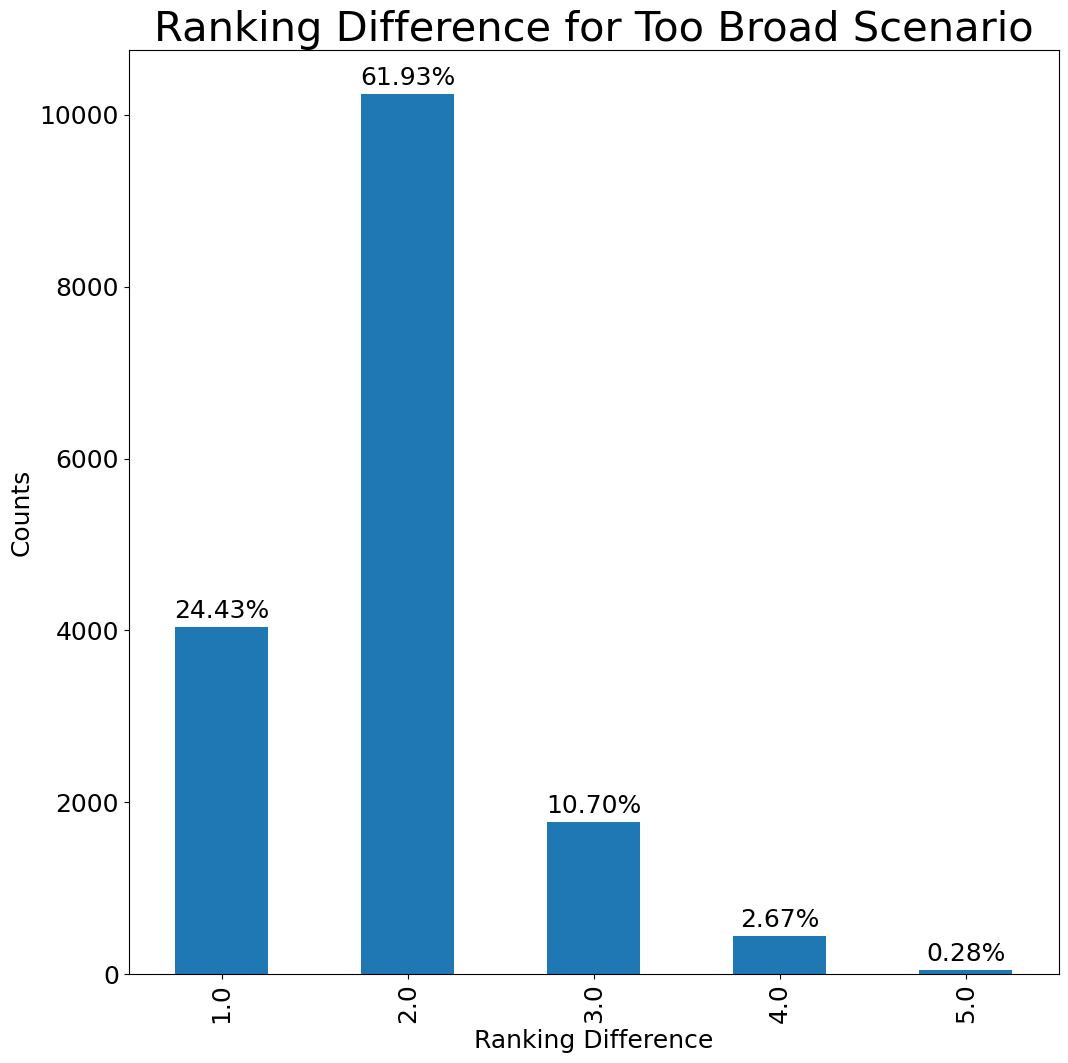

In [296]:
plt.figure(figsize=(12, 12))
ranking_diff_counts = results[results["scenario"] == "too_broad"]["ranking_diff"].value_counts().sort_index()

# Calculate the percentage
ranking_diff_percentages = (ranking_diff_counts / ranking_diff_counts.sum()) * 100

# Plot the counts
ax = ranking_diff_counts.plot(kind='bar', title='Ranking Difference for Too Broad Scenario', fontsize=18)
ax.set_title('Ranking Difference for Too Broad Scenario', fontsize=30)
ax.set_xlabel("Ranking Difference", fontsize=18)
ax.set_ylabel("Counts", fontsize=18)

# Add percentages on top of the bars
for i, count in enumerate(ranking_diff_counts):
    percentage = ranking_diff_percentages[i+1]
    ax.text(i, count + 50, f'{percentage:.2f}%', ha='center', va='bottom', fontsize=18)
plt.show()
# ranking_diff_counts = results[results["scenario"] == "too_broad"]["ranking_diff"].value_counts().sort_index()
# ax = ranking_diff_counts.plot(kind='bar', title='Ranking Difference for Too Broad Scenario', xlabel='Ranking Difference', ylabel='Counts')


In [489]:
# results.to_csv('../csv_folder/antibiotic_appropriateness.csv', index=False)

In [183]:
df_hosp_ward_info[(df_hosp_ward_info['hosp_ward_OP'] == 1) & (df_hosp_ward_info['hosp_ward_ER'] == 1)]

,anon_id,pat_enc_csn_id_coded,order_proc_id_coded,order_time_jittered_utc,hosp_ward_IP,hosp_ward_OP,hosp_ward_ER,hosp_ward_ICU
347979,JC3243957,131288047970,662720316,2020-06-04 22:01:00+00:00,0,1,1,1
347980,JC1783941,131355397449,879930149,2023-06-02 20:17:00+00:00,0,1,1,0


In [220]:
find_unique_orders(starting_cohort[starting_cohort["ordering_mode"] == "Outpatient"])

246340